In [1]:
from msdm.domains import GridWorld
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.algorithms import ValueIteration
from msdm.core.problemclasses.mdp import TabularPolicy
from algorithms import MaxLikelihoodIRL
import torch
from frozendict import frozendict
from dataset import TrajectoryDataset
from torch.utils.data import DataLoader

In [2]:
torch.cuda.current_device()

0

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

# Corresponds to superv_example3_10000_50epoch

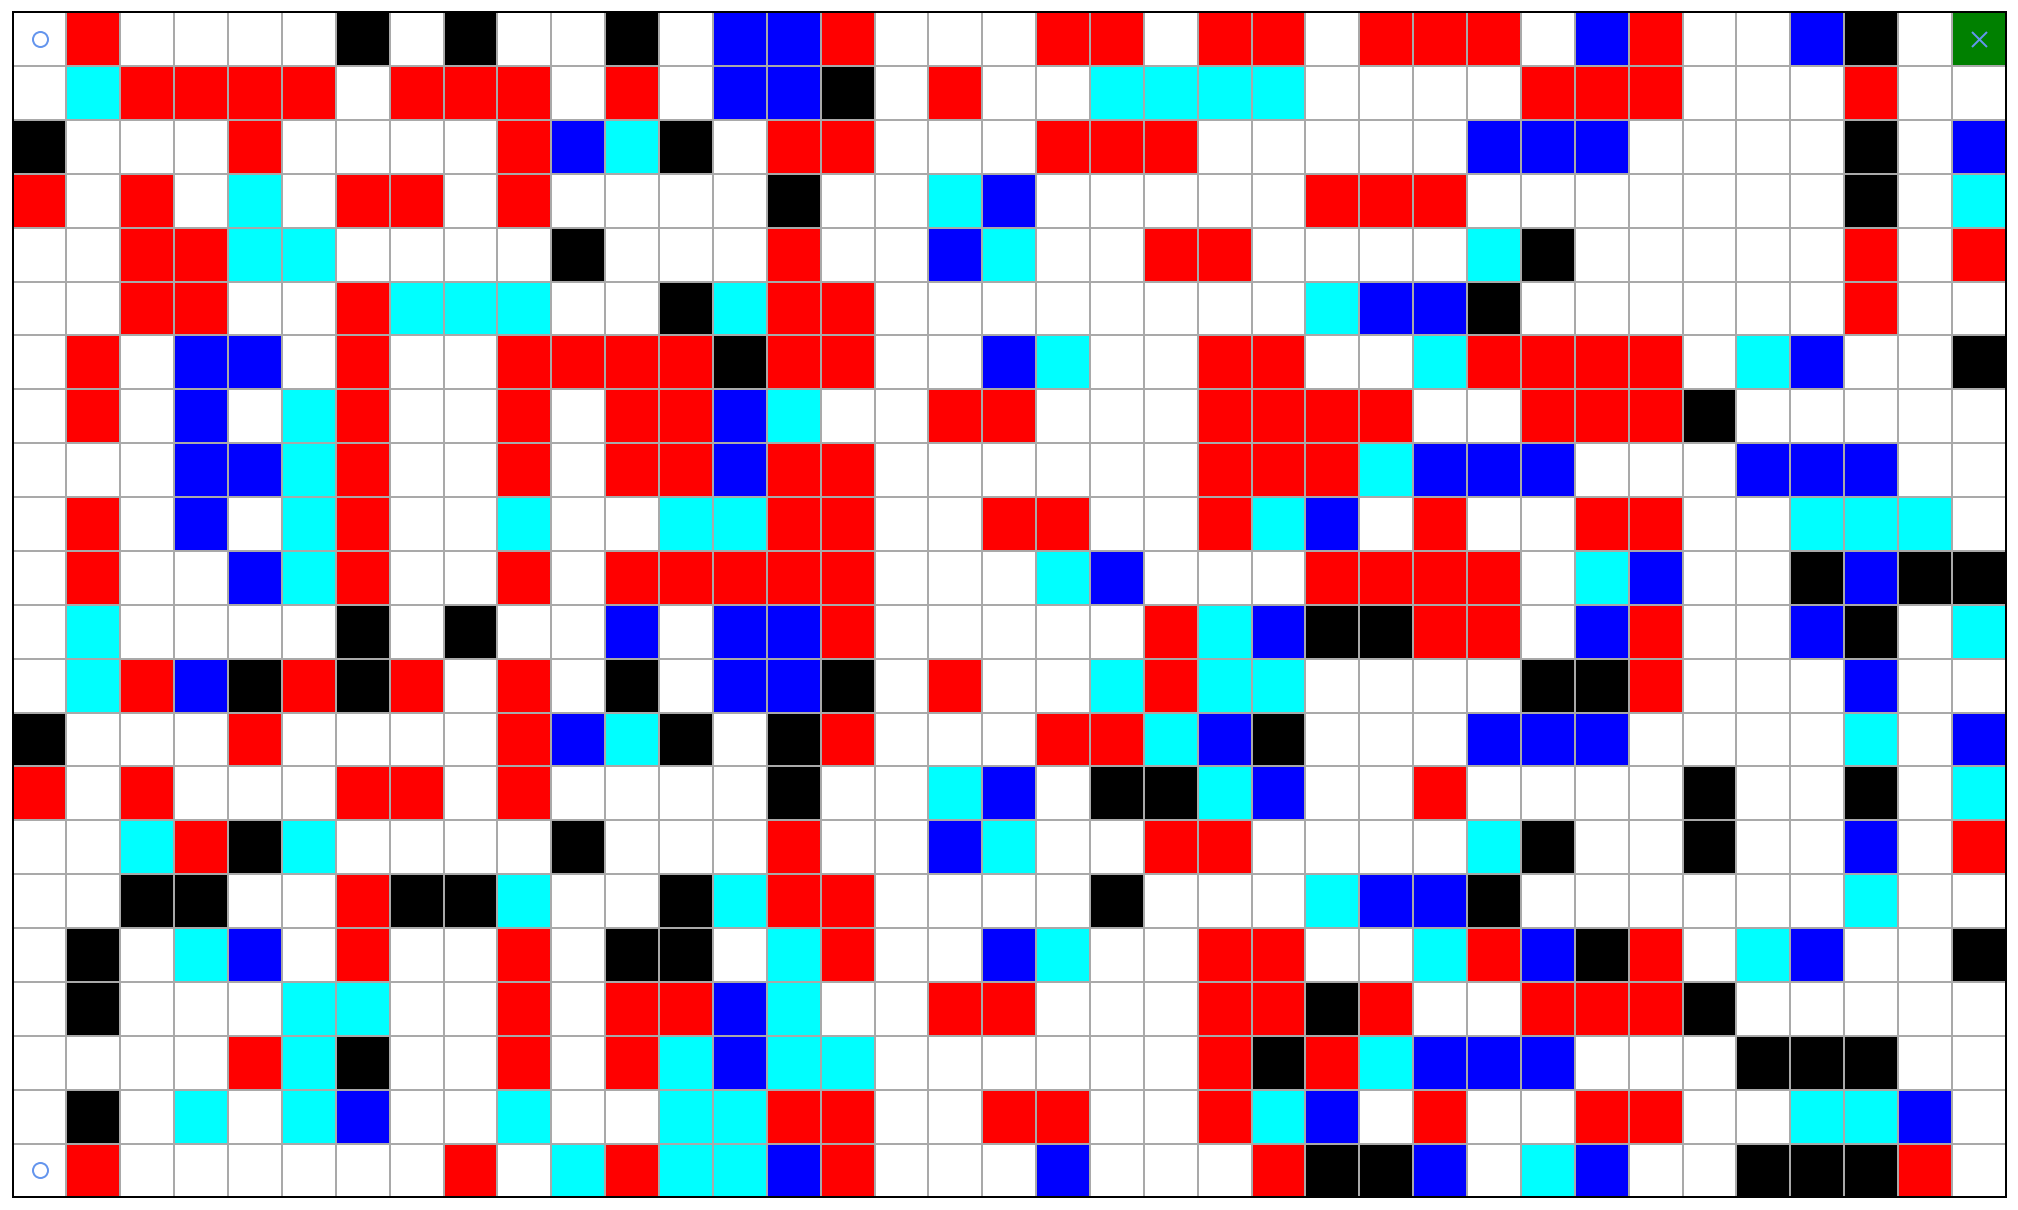

In [5]:
# Create a gridworld
mdp_params = dict(
    tile_array=[
        "sx....c.c..c.bbx...xx.xx.xxx.bx..bc.g",
        ".axxxx.xxx.x.bbc.x..aaaa....xxx...x..",
        "c...x....xbac.xx...xxx.....bbb....c.b",
        "x.x.a.xx.x....c..ab.....xxx.......c.a",
        "..xxaa....c...x..ba..xx....ac.....x.x",
        "..xx..xaaa..caxx........abbc......x..",
        ".x.bb.x..xxxxcxx..ba..xx..axxxx.ab..c",
        ".x.b.ax..x.xxba..xx...xxxx..xxxc.....",
        "...bbax..x.xxbxx......xxxabbb...bbb..",
        ".x.b.ax..a..aaxx..xx..xab.x..xx..aaa.",
        ".x..bax..x.xxxxx...ab...xxxx.ab..cbcc",
        ".a....c.c..b.bbx.....xabccxx.bx..bc.a",
        ".axbcxcx.x.c.bbc.x..axaa....ccx...b..",
        "c...x....xbac.cx...xxabc...bbb....a.b",
        "x.x...xx.x....c..ab.ccab..x....c..c.a",
        "..axca....c...x..ba..xx....ac..c..b.x",
        "..cc..xcca..caxx....c...abbc......a..",
        ".c.ab.x..x.cc.ax..ba..xx..axbcx.ab..c",
        ".c...aa..x.xxba..xx...xxcx..xxxc.....",
        "....xac..x.xabaa......xcxabbb...ccc..",
        ".c.a.ab..a..aaxx..xx..xab.x..xx..aab.",
        "sx......x.axaabx...b...xccb.ab..cccx.",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp = GridWorld(**mdp_params)

featurecolors = {
    'g': 'green',
    'x': 'red',
    '.': 'white',
    'b': 'blue',
    'a': 'cyan',
    'c': 'black'
}
mdp.plot(featurecolors=featurecolors)


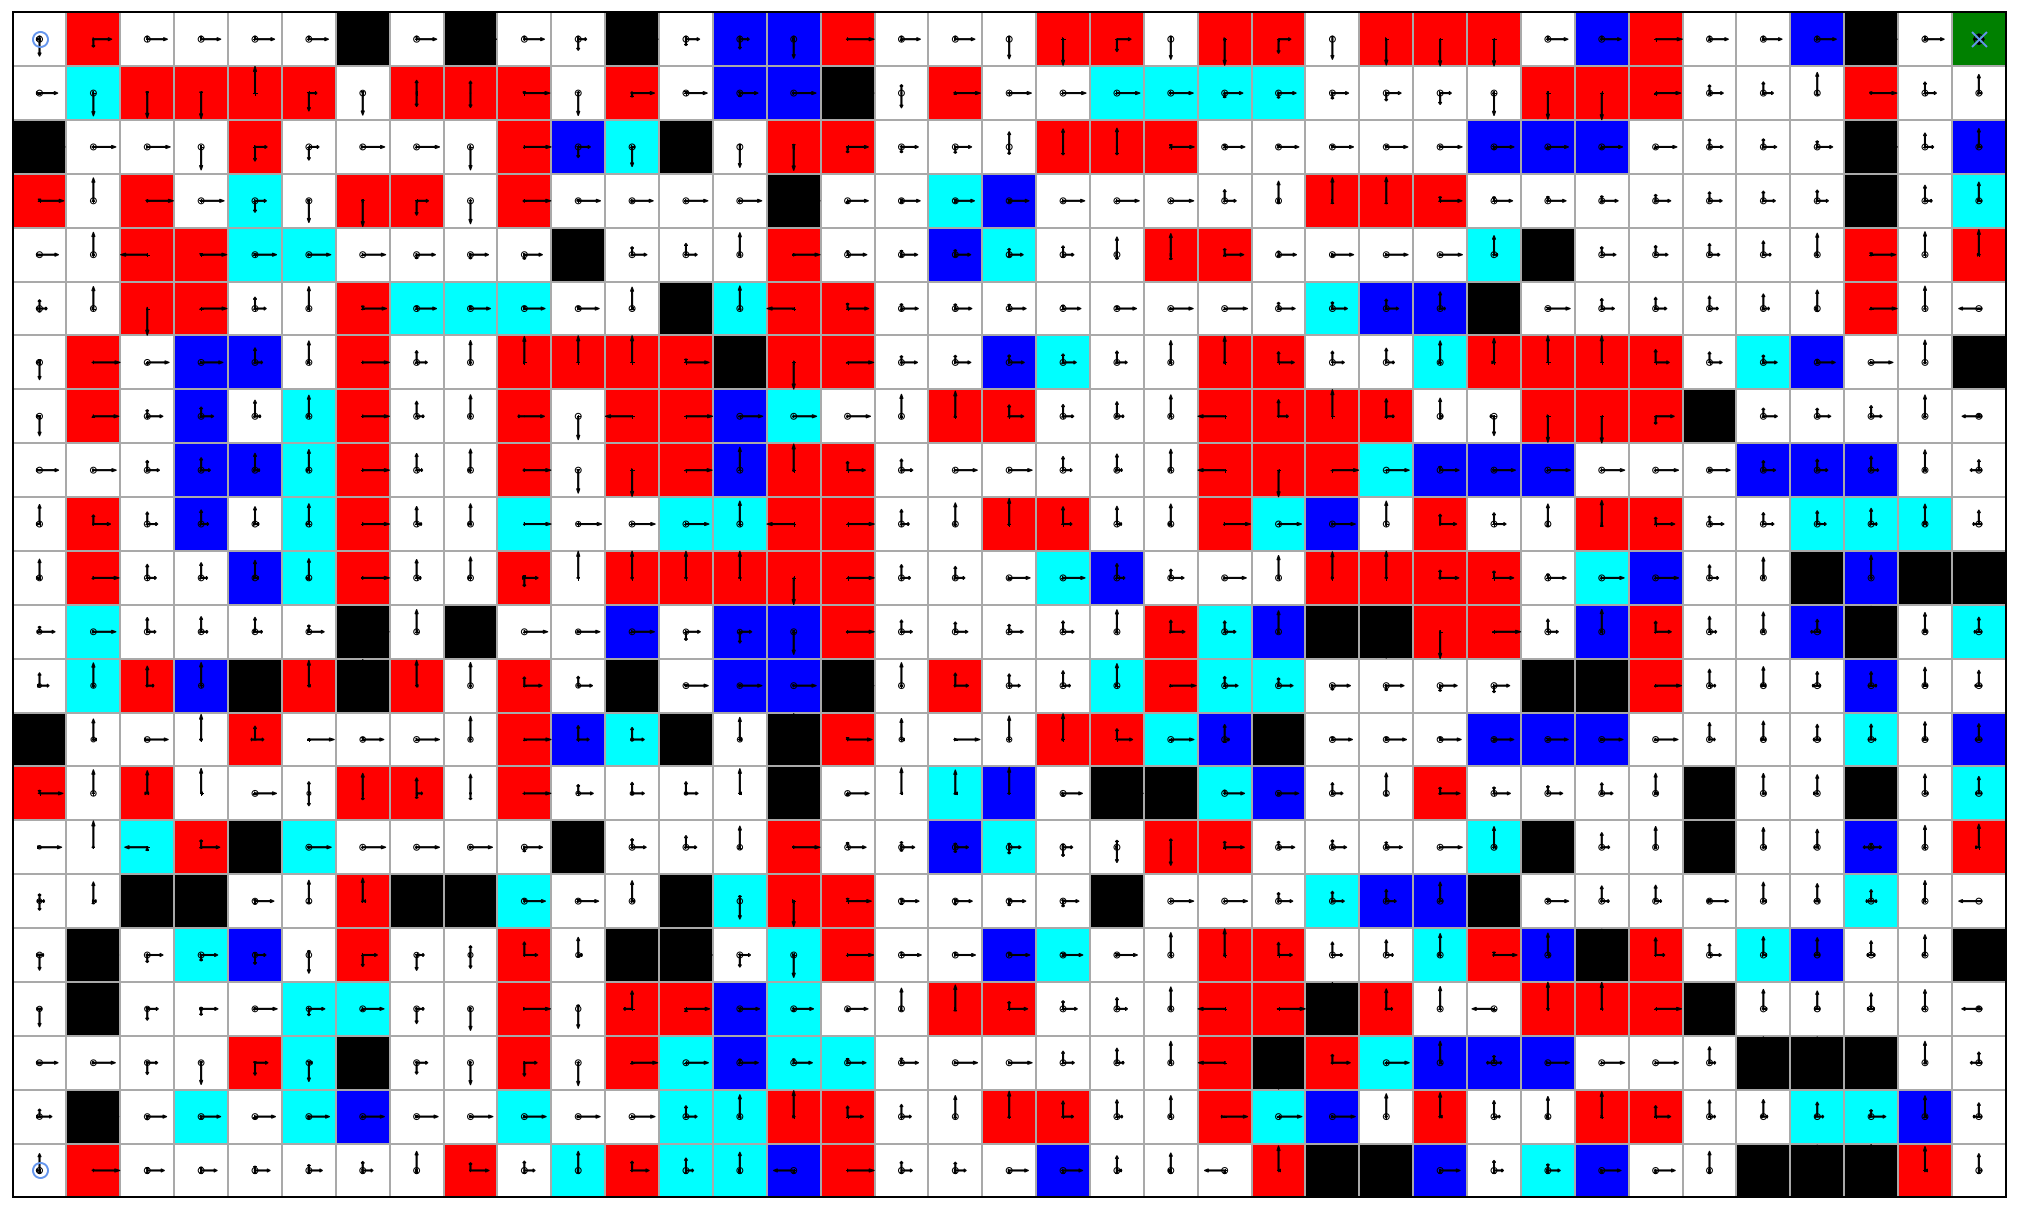

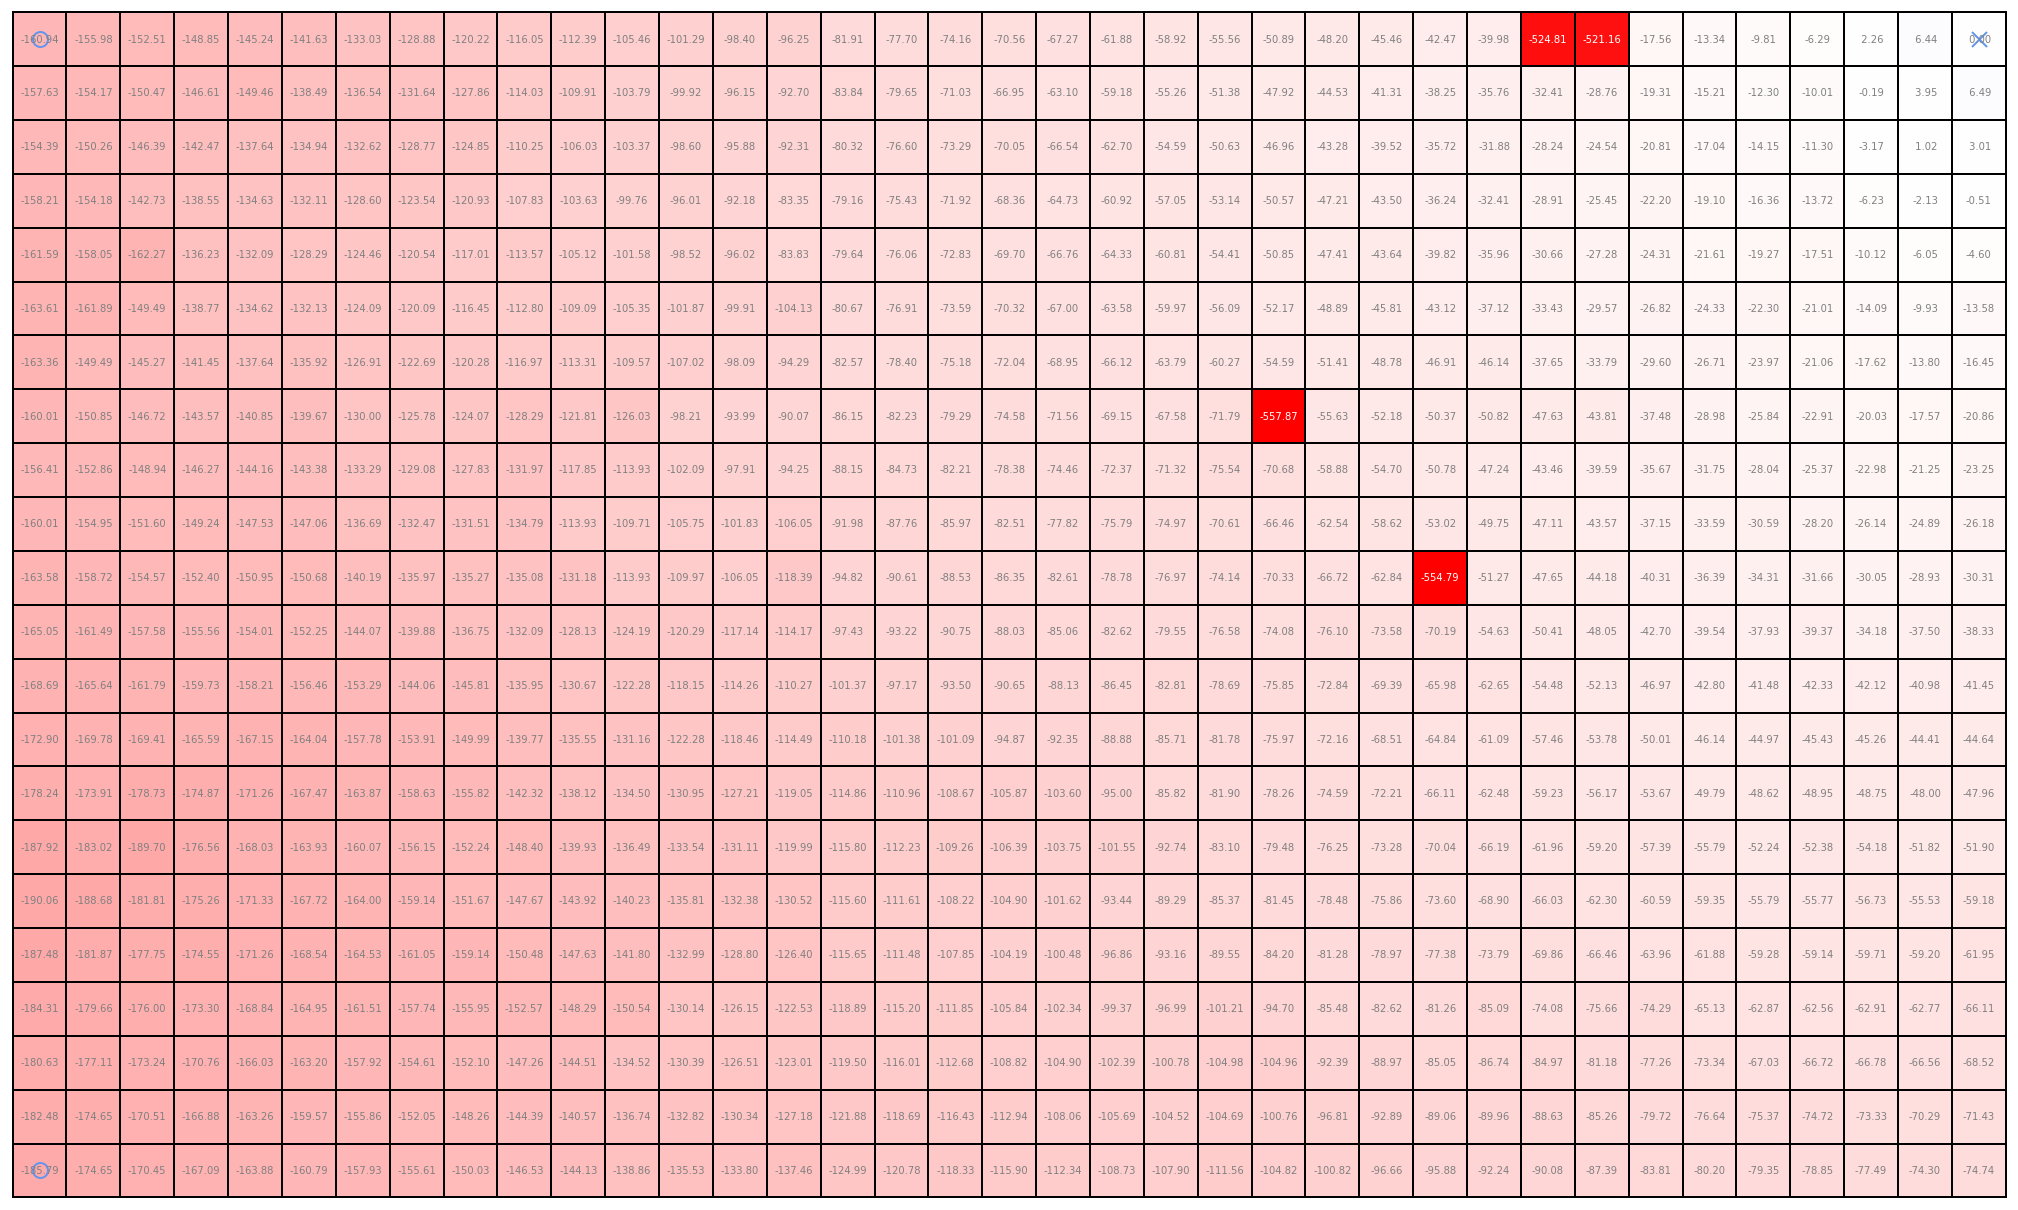

In [6]:
# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp.state_list, expert_erpi.state_values))
mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [7]:
# Generate gen_iters of trajectories
gen_iters = 10000
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

trajs_dataset = TrajectoryDataset(trajectories)

In [8]:
def featurizer(state, action, next_state):
  feature_name = mdp.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}

def fixed_reward(state, action, next_state):
  return mdp.step_cost

In [9]:
algorithm = MaxLikelihoodIRL(mdp, featurizer, fixed_reward, batch_size=128, epochs=50, entropy_weight=2)
learned_weights, the_policy = algorithm.learn(trajs_dataset)

Using cuda
Inital reward weights: tensor([-1.4930, -0.4615,  0.0552,  0.2228], dtype=torch.float64)

loss: 1.116884  [    0/10000]
loss: 1.046113  [  256/10000]
loss: 1.011727  [  512/10000]
loss: 1.021008  [  768/10000]
loss: 0.987469  [ 1024/10000]
loss: 0.980916  [ 1280/10000]
loss: 0.994490  [ 1536/10000]
loss: 0.968192  [ 1792/10000]
loss: 0.944045  [ 2048/10000]
loss: 0.928146  [ 2304/10000]
loss: 0.932986  [ 2560/10000]
loss: 0.930842  [ 2816/10000]
loss: 0.906161  [ 3072/10000]
loss: 0.833513  [ 3328/10000]
loss: 0.890673  [ 3584/10000]
loss: 0.860085  [ 3840/10000]
loss: 0.903920  [ 4096/10000]
loss: 0.861649  [ 4352/10000]
loss: 0.872102  [ 4608/10000]
loss: 0.856866  [ 4864/10000]
loss: 0.868573  [ 5120/10000]
loss: 0.873892  [ 5376/10000]
loss: 0.871072  [ 5632/10000]
loss: 0.843714  [ 5888/10000]
loss: 0.809720  [ 6144/10000]
loss: 0.838644  [ 6400/10000]
loss: 0.846117  [ 6656/10000]
loss: 0.822687  [ 6912/10000]
loss: 0.823675  [ 7168/10000]
loss: 0.860475  [ 7424/10000]

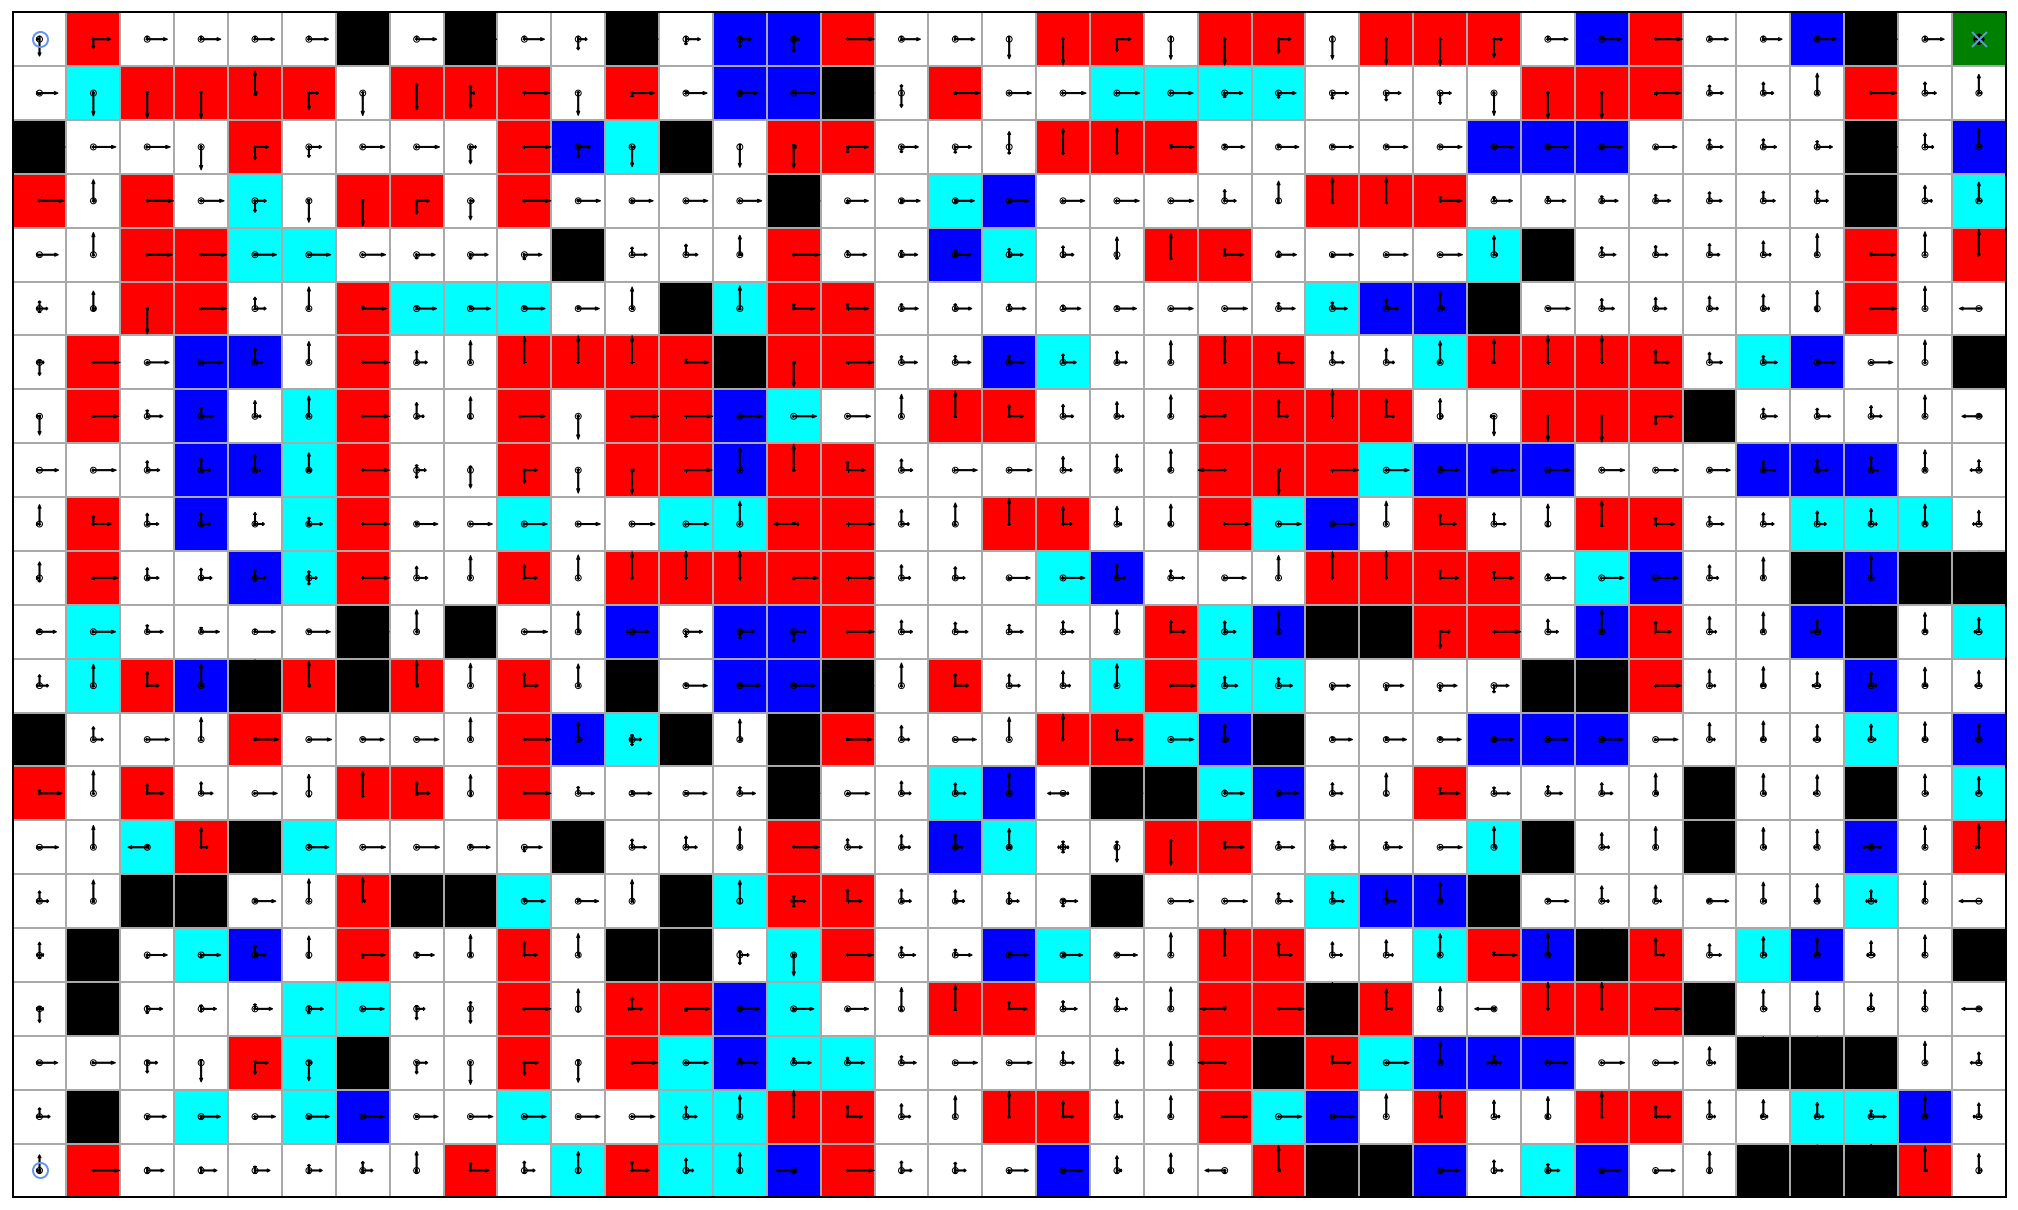

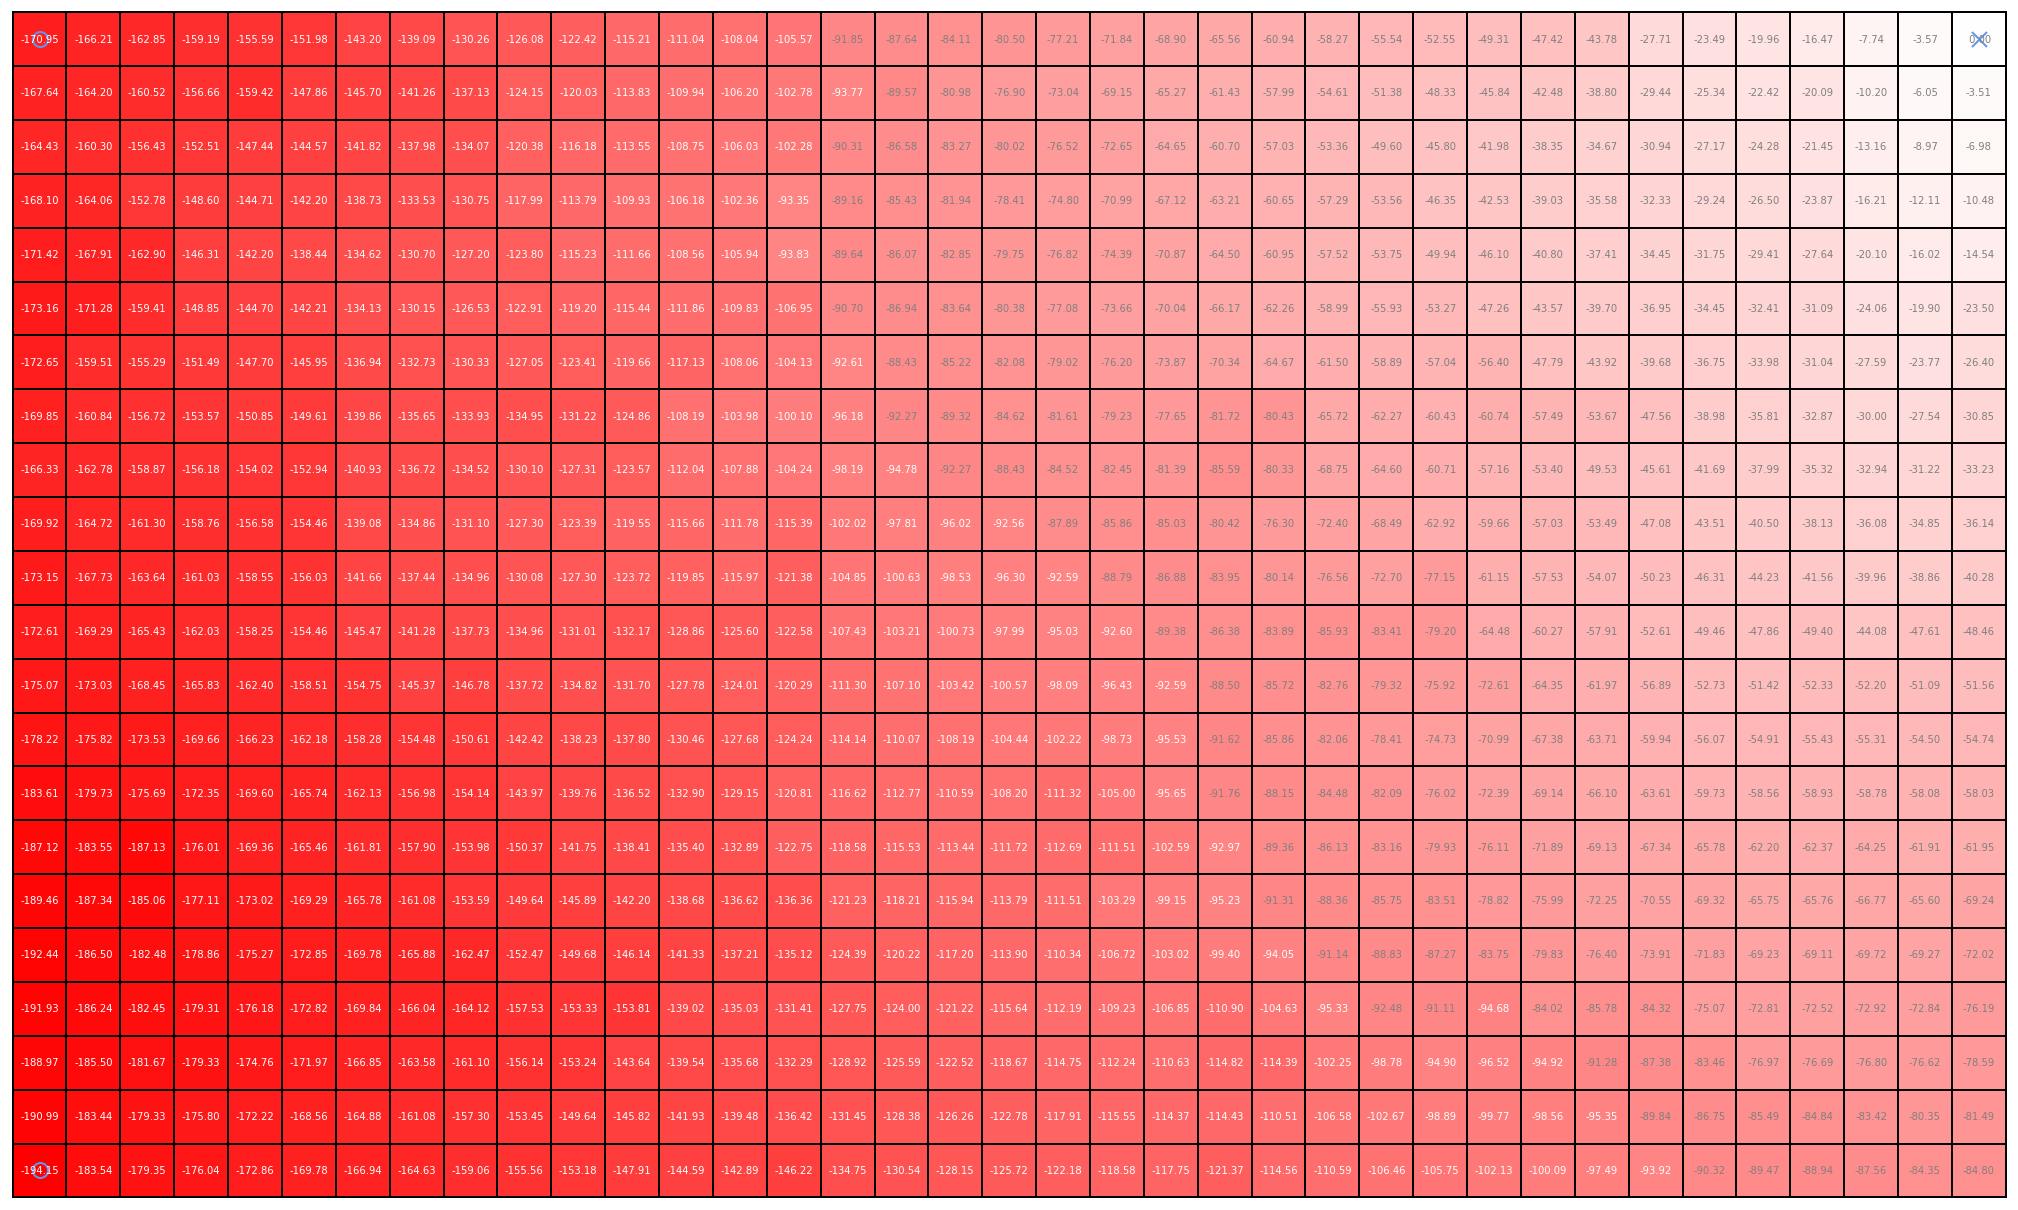

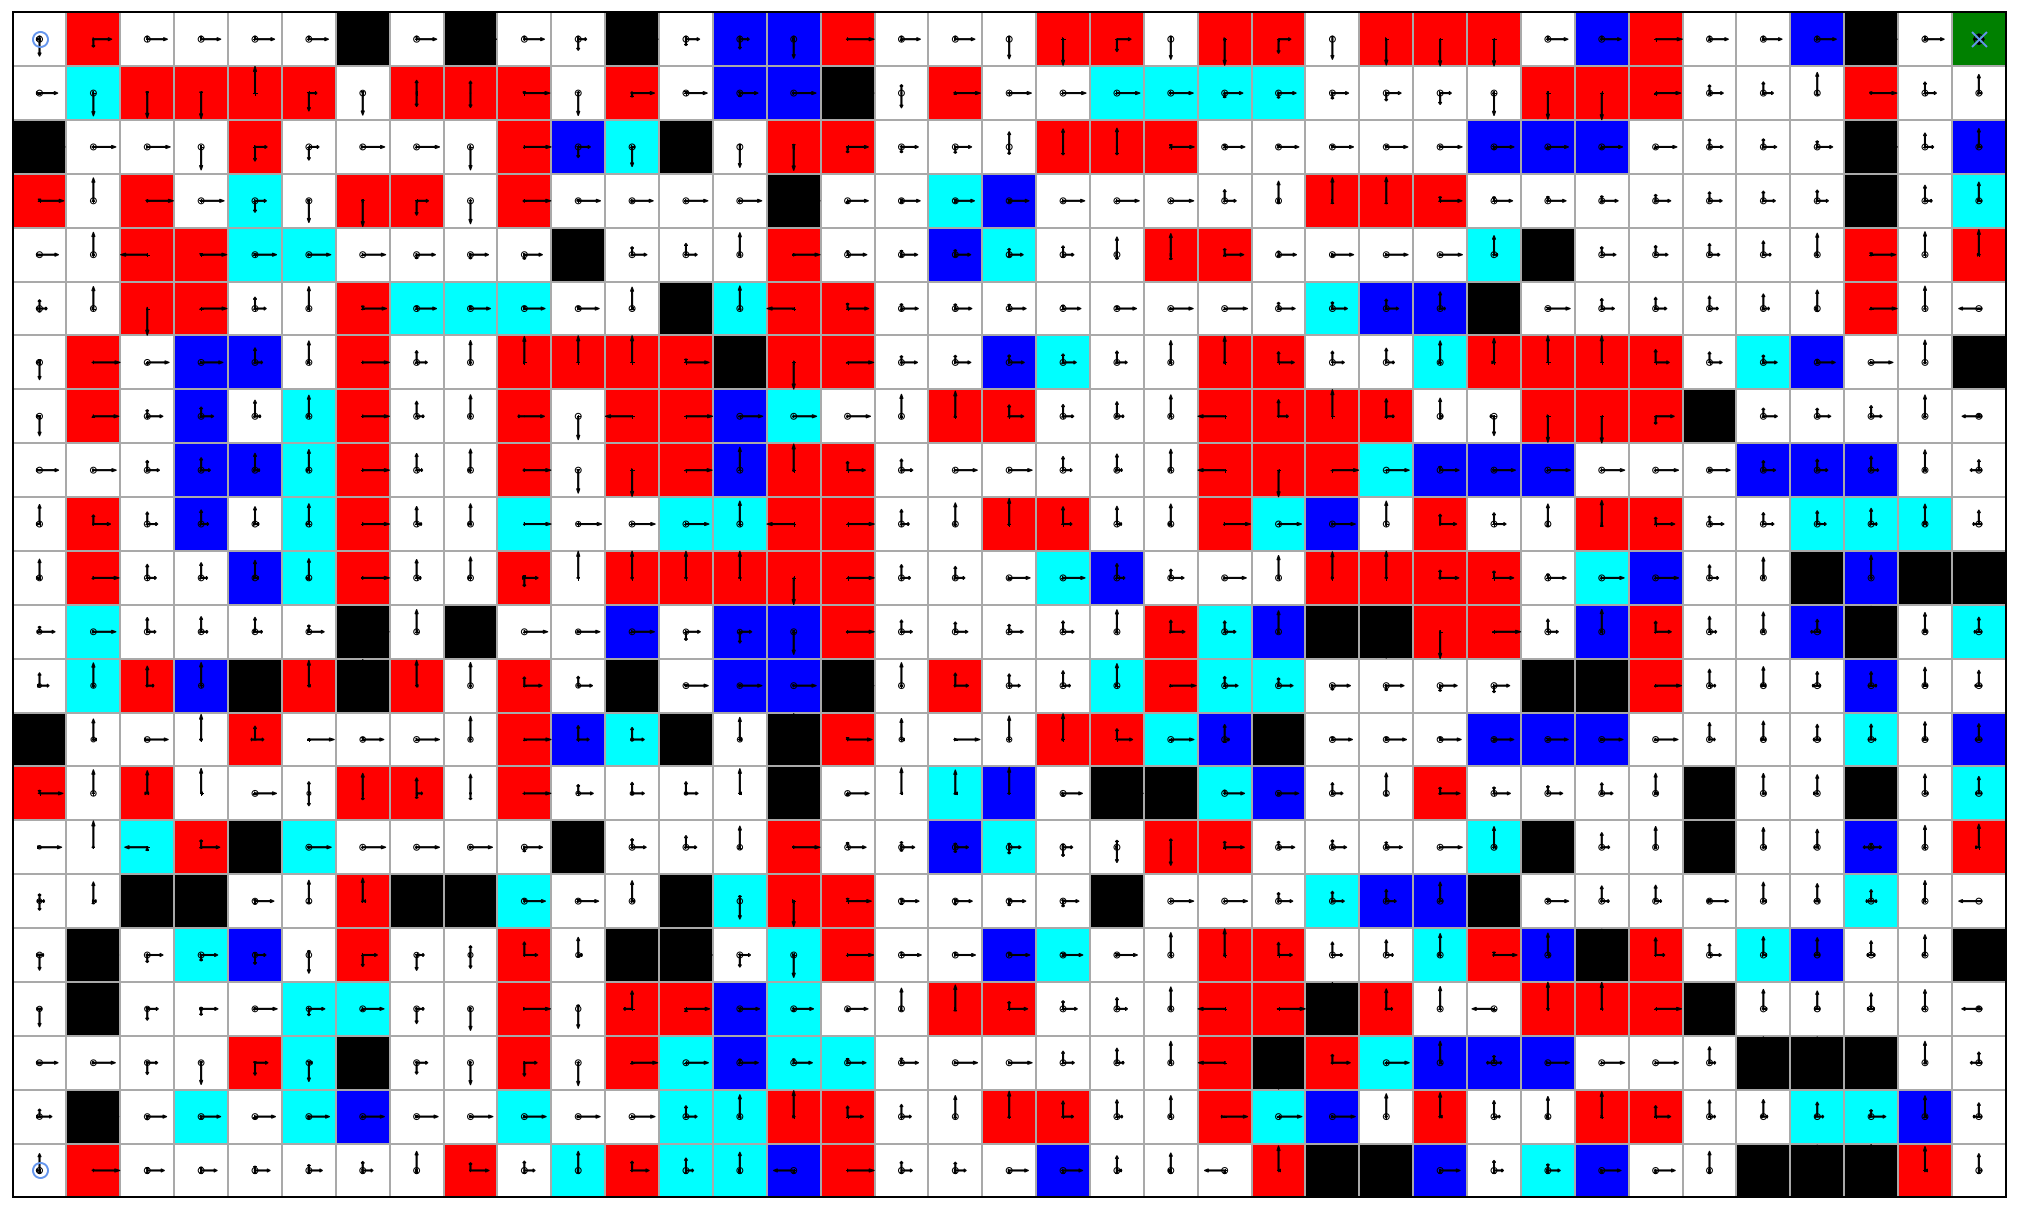

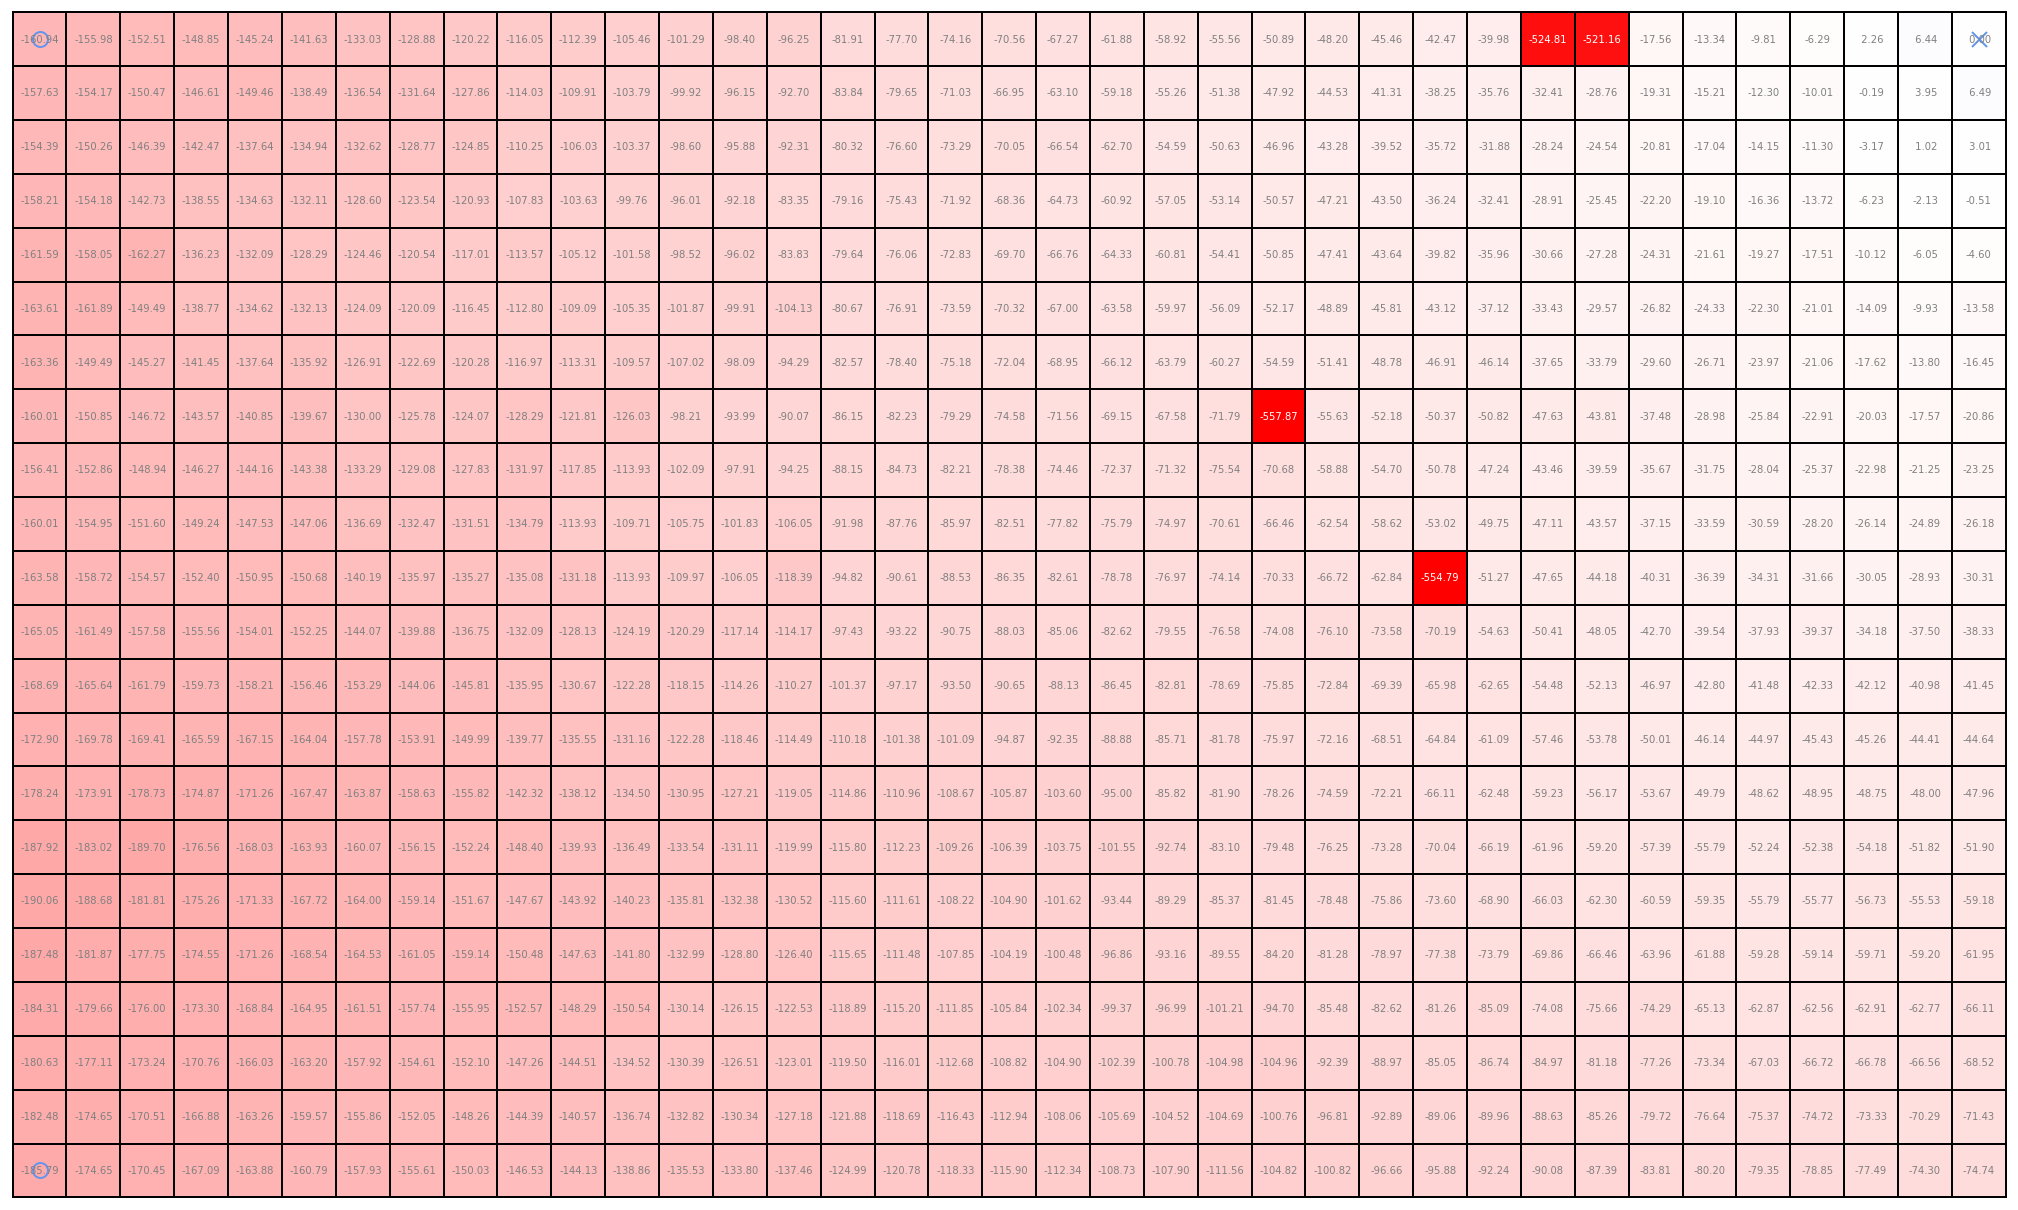

In [10]:
# solve with matrices returned by gridworld object
my_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=the_policy.policy.detach().numpy()
)

my_state_values = dict(zip(mdp.state_list, the_policy.state_values.detach()))
mdp.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp.plot().plot_state_map(my_state_values)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [11]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp).initial_value}")


Learned policy's initial value: -116.28408900236911
Expert's policy initial value: -67.593535619632


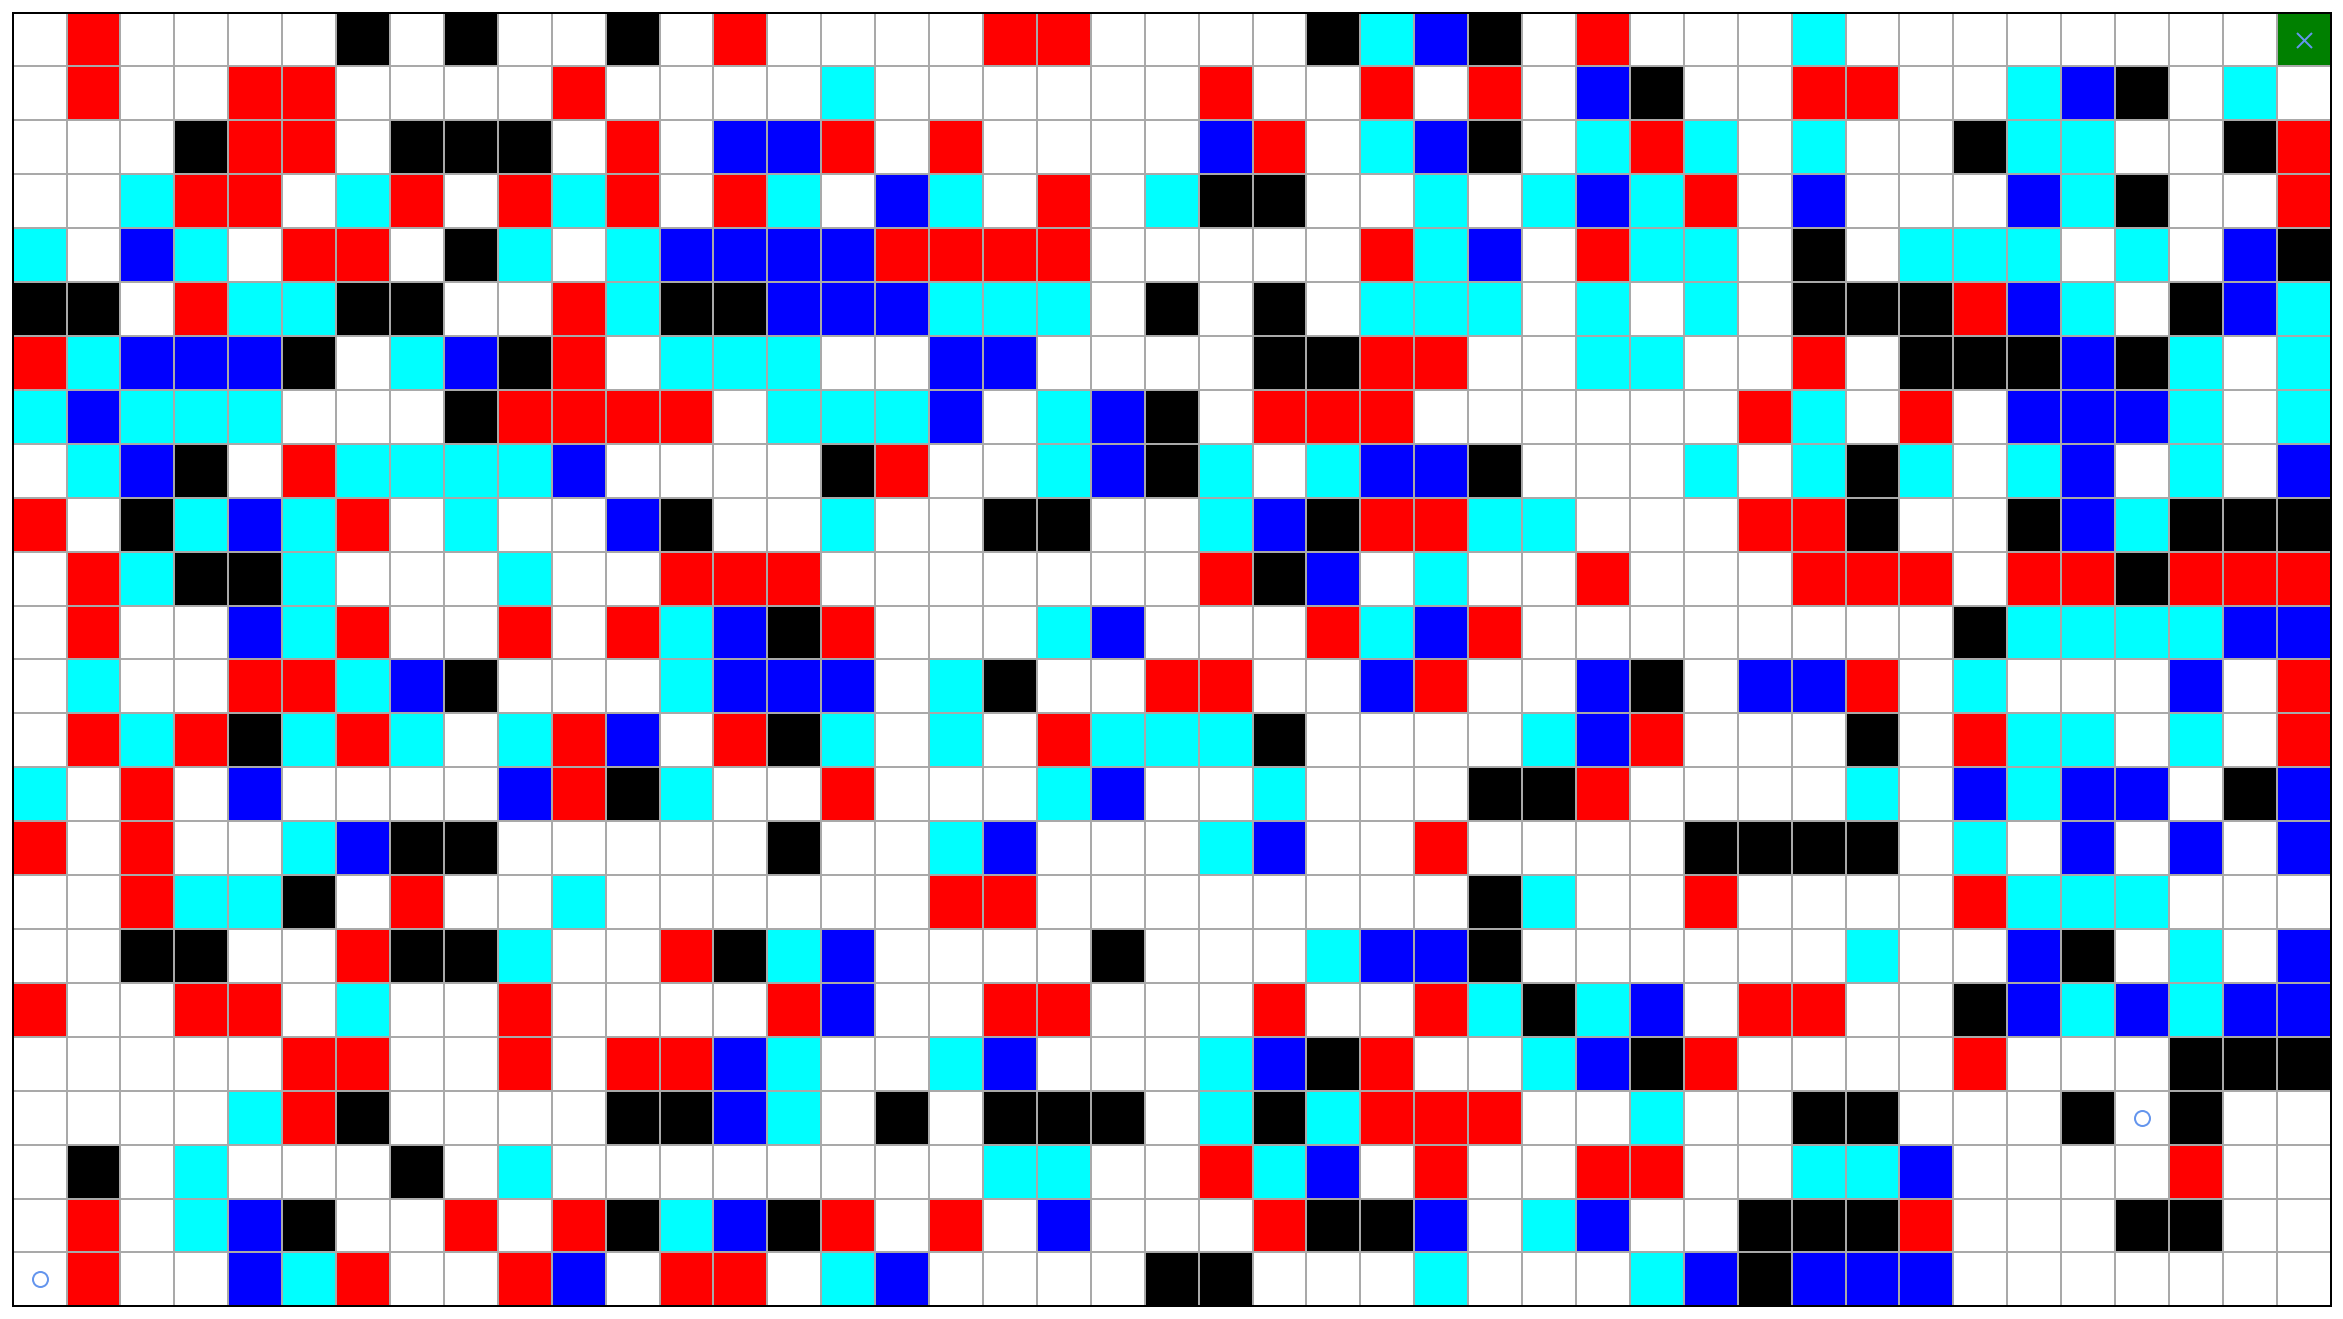

In [25]:
# Test learned reward weights on a novel gridworld
mdp2_params = dict(
    tile_array=[
        ".x....c.c..c.x....xx....cabc.x...a........g",
        ".x..xx....x....a......x..x.x.bc..xx..abc.a.",
        "...cxx.ccc.x.bbx.x....bx.abc.axa.a..caa..cx",
        "..axx.ax.xax.xa.ba.x.acc..a.abax.b...bac..x",
        "a.ba.xx.ca.abbbbxxxx.....xab.xaa.c.aaa.a.bc",
        "cc.xaacc..xaccbbbaaa.c.c.aaa.a.a.cccxba.cba",
        "xabbbc.abcx.aaa..bb....ccxx..aa..x.cccbca.a",
        "abaaa...cxxxx.aaab.abc.xxx......xa.x.bbba.a",
        ".abc.xaaaab....cx..abca.abbc...a.aca.ab.a.b",
        "x.cabax.a..bc..a..cc..abcxxaa...xxc..cbaccc",
        ".xacca...a..xxx.......xcb.a..x...xxx.xxcxxx",
        ".x..bax..x.xabcx...ab...xabx........caaaabb",
        ".a..xxabc...abbb.ac..xx..bx..bc.bbx.a...b.x",
        ".xaxcaxa.axb.xca.a.xaaac....abx...c.xaa.a.x",
        "a.x.b....bxca..x...ab..a...ccx....a.babb.cb",
        "x.x..abcc.....c..ab...ab..x....cccc.a.b.b.b",
        "..xaac.x..a......xx........ca..x....xaaa...",
        "..cc..xcca..xcab....c...abbc......a..bc.a.b",
        "x..xx.a..x....xb..xx...x..xacab.xx..cbababb",
        ".....xx..x.xxba..ab...abcx..abcx....x...ccc",
        "....axc....ccba.c.ccc.acaxxx..a..cc...csc..",
        ".c.a...c.a........aa..xab.x..xx..aab....x..",
        ".x.abc..x.xcabcx.x.b...xccb.ab..cccx...cc..",
        "sx..bax..xb.xx.ab....cc...a...abcbbb.......",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp2 = GridWorld(**mdp2_params)

mdp2.plot(featurecolors=featurecolors)


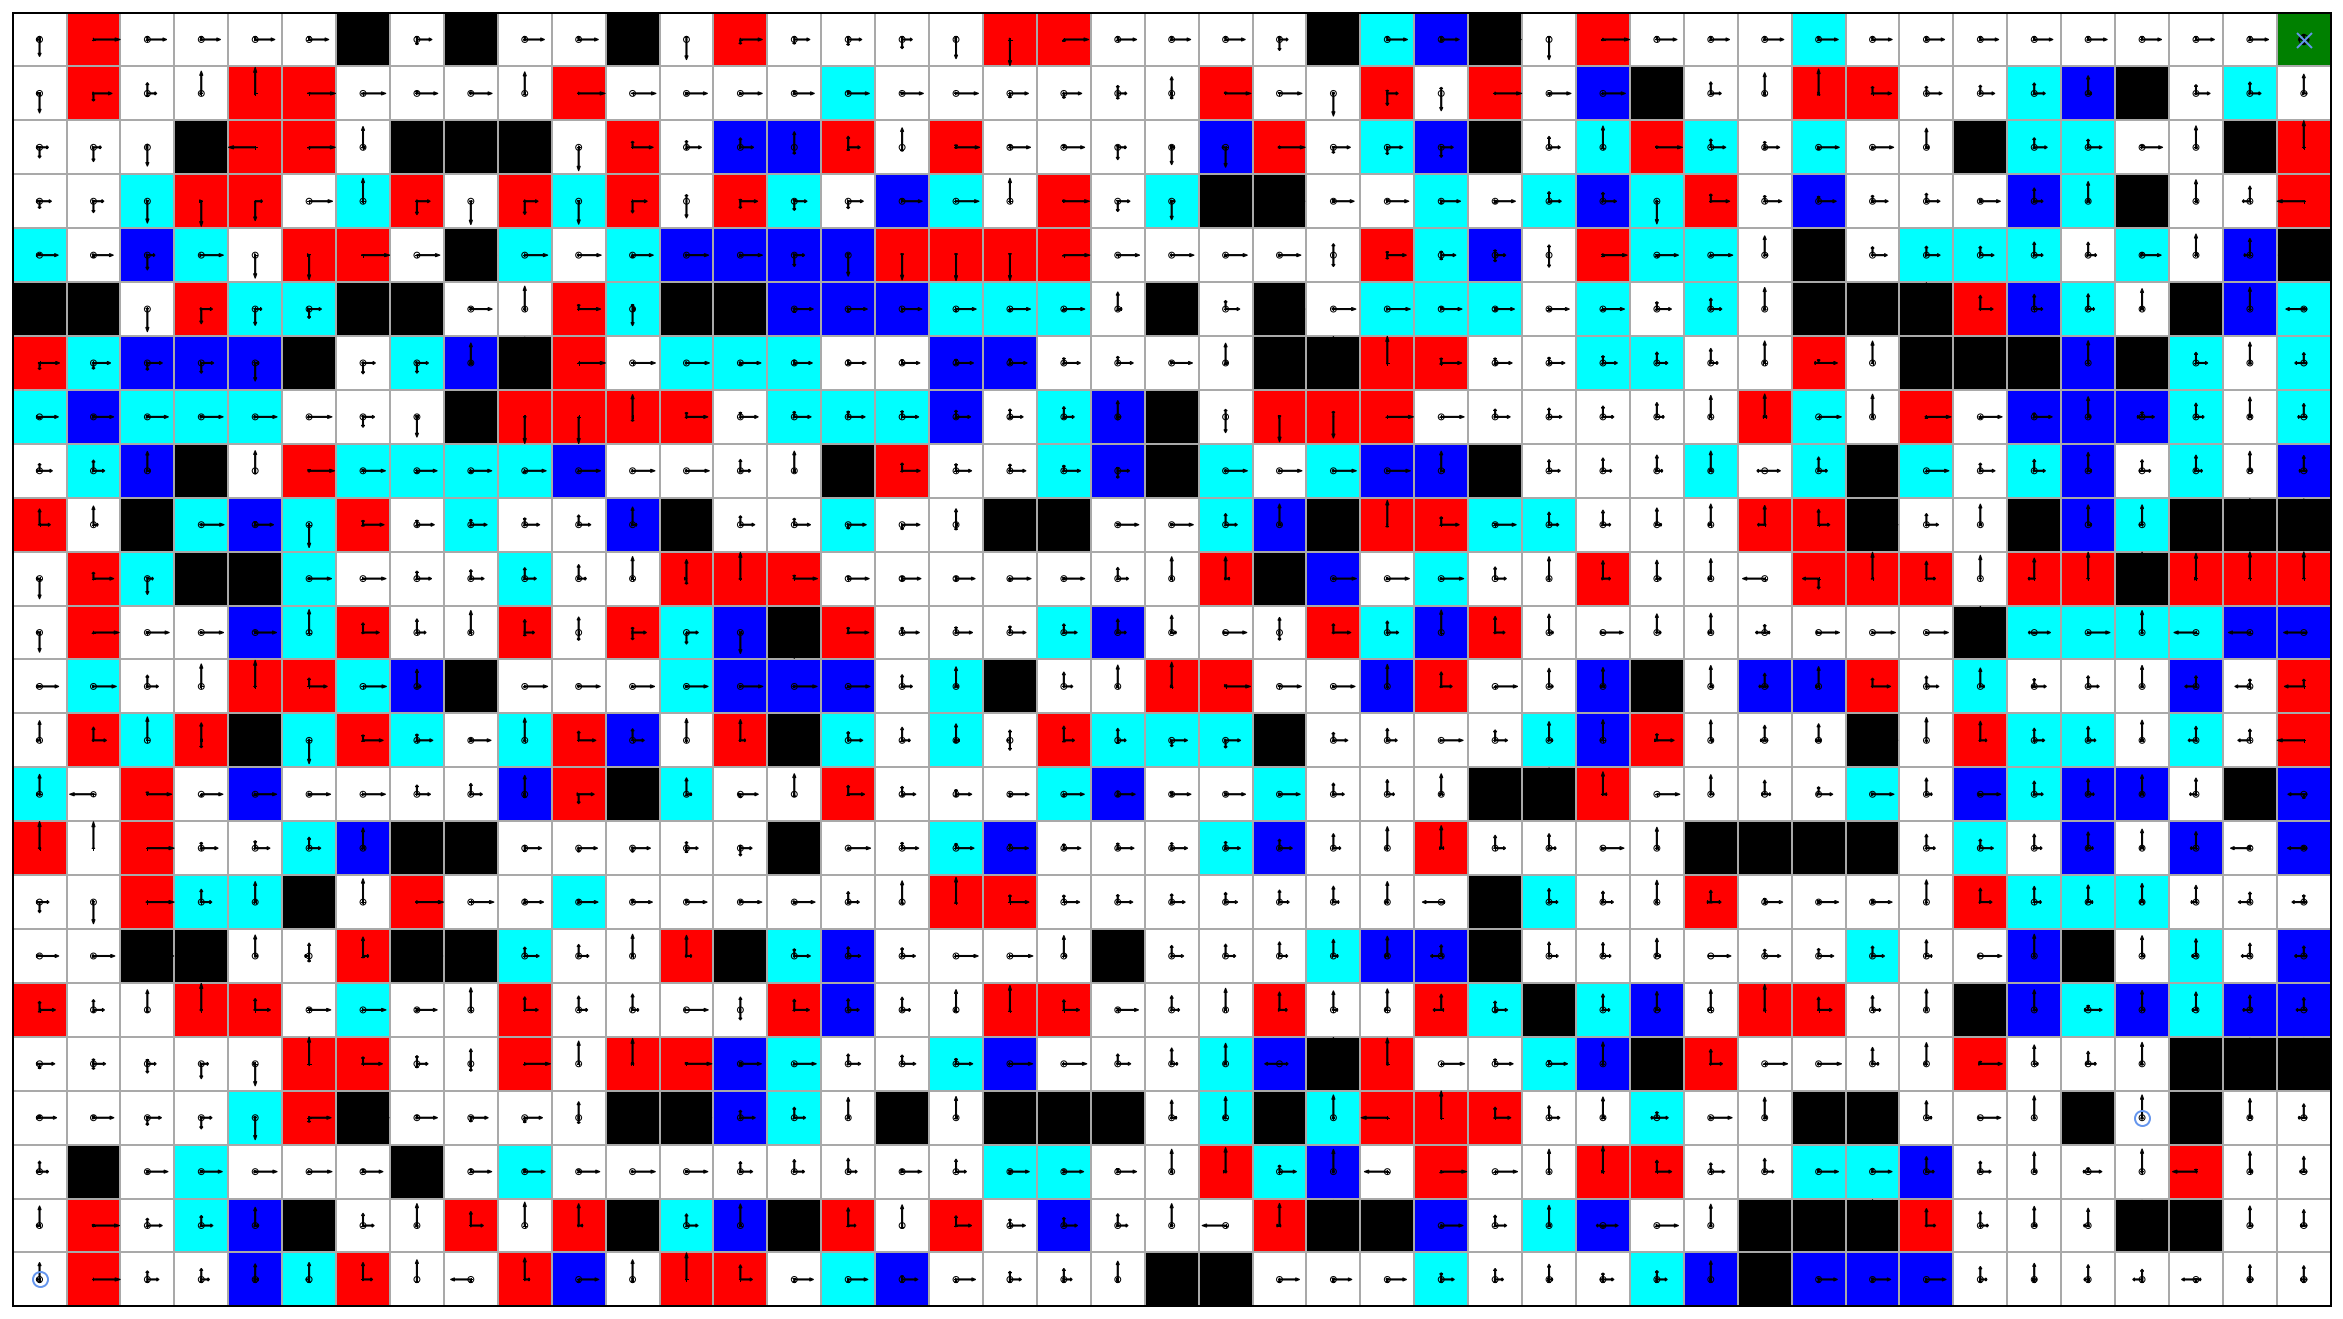

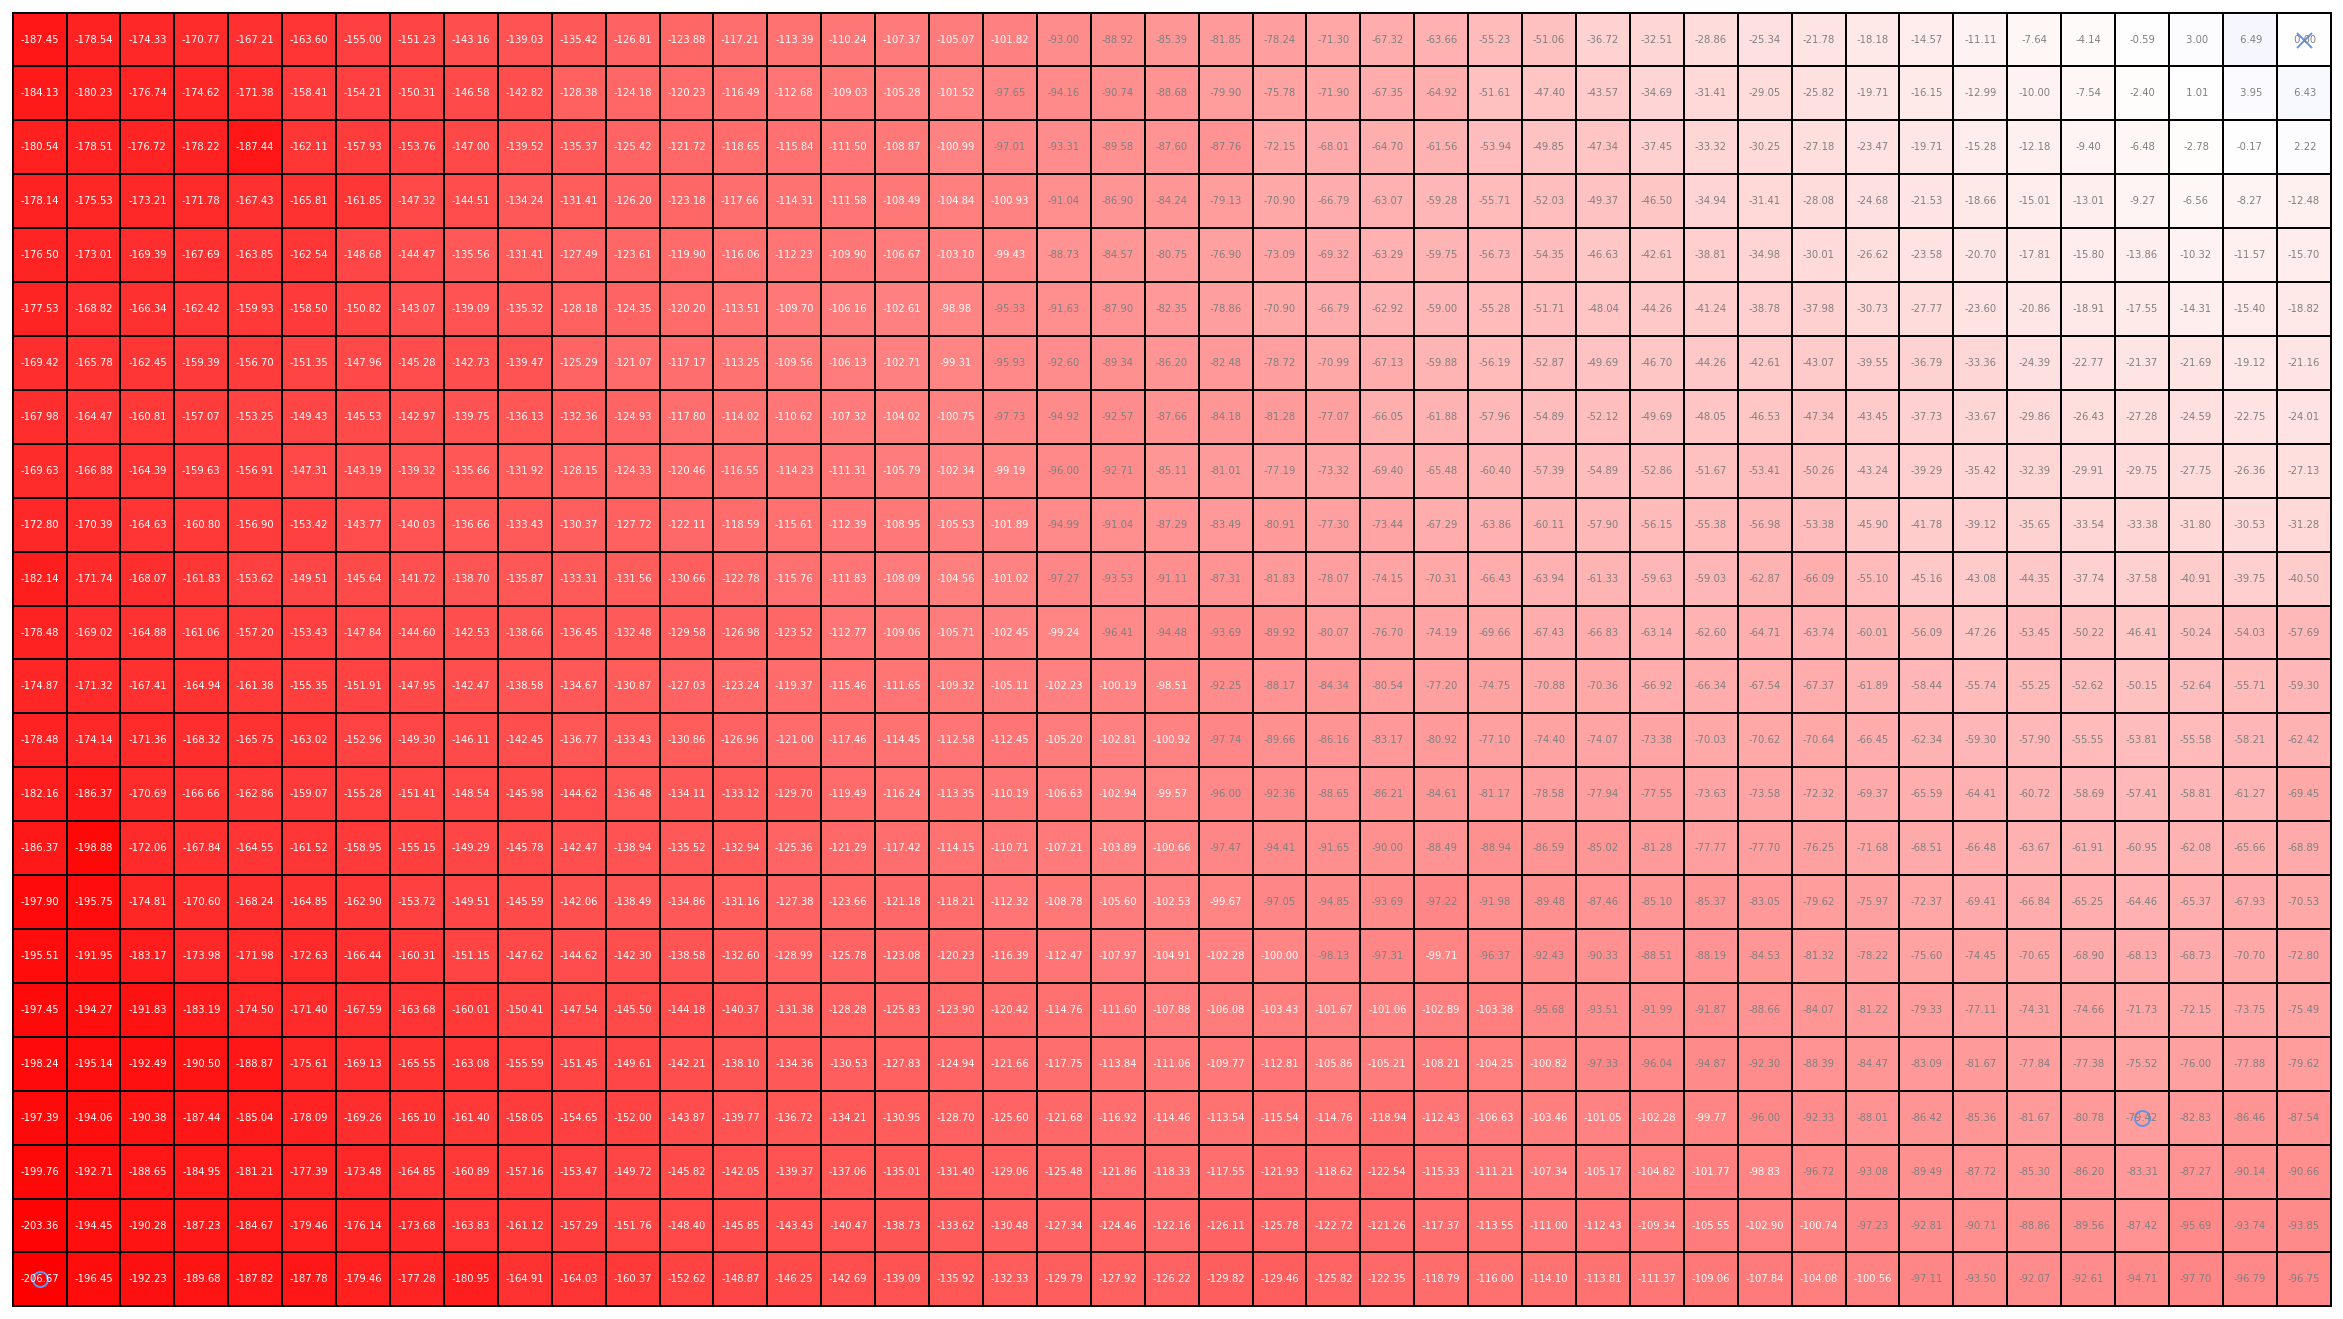

In [26]:
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp2.state_list, expert_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [27]:
def featurizer(state, action, next_state):
  feature_name = mdp2.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}


def fixed_reward(state, action, next_state):
  return mdp2.step_cost


In [29]:
algorithm2 = MaxLikelihoodIRL(mdp2, featurizer, fixed_reward, batch_size=128, epochs=50, entropy_weight=2)

# compute policy from learned weights
feature_reward_matrix2 = torch.einsum(
    "sanf,f->san",
    algorithm2.get_feature_matrix(),
    learned_weights
)

reward_matrix2 = feature_reward_matrix2 + algorithm2.get_fixed_reward_matrix()
terminal_index = mdp2.state_index.get(
    frozendict({'x': -1, 'y': -1}))
reward_matrix2[:, :, terminal_index] = 0

my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=reward_matrix2,
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


torch.Size([1033, 5, 1033, 4])
torch.Size([4])


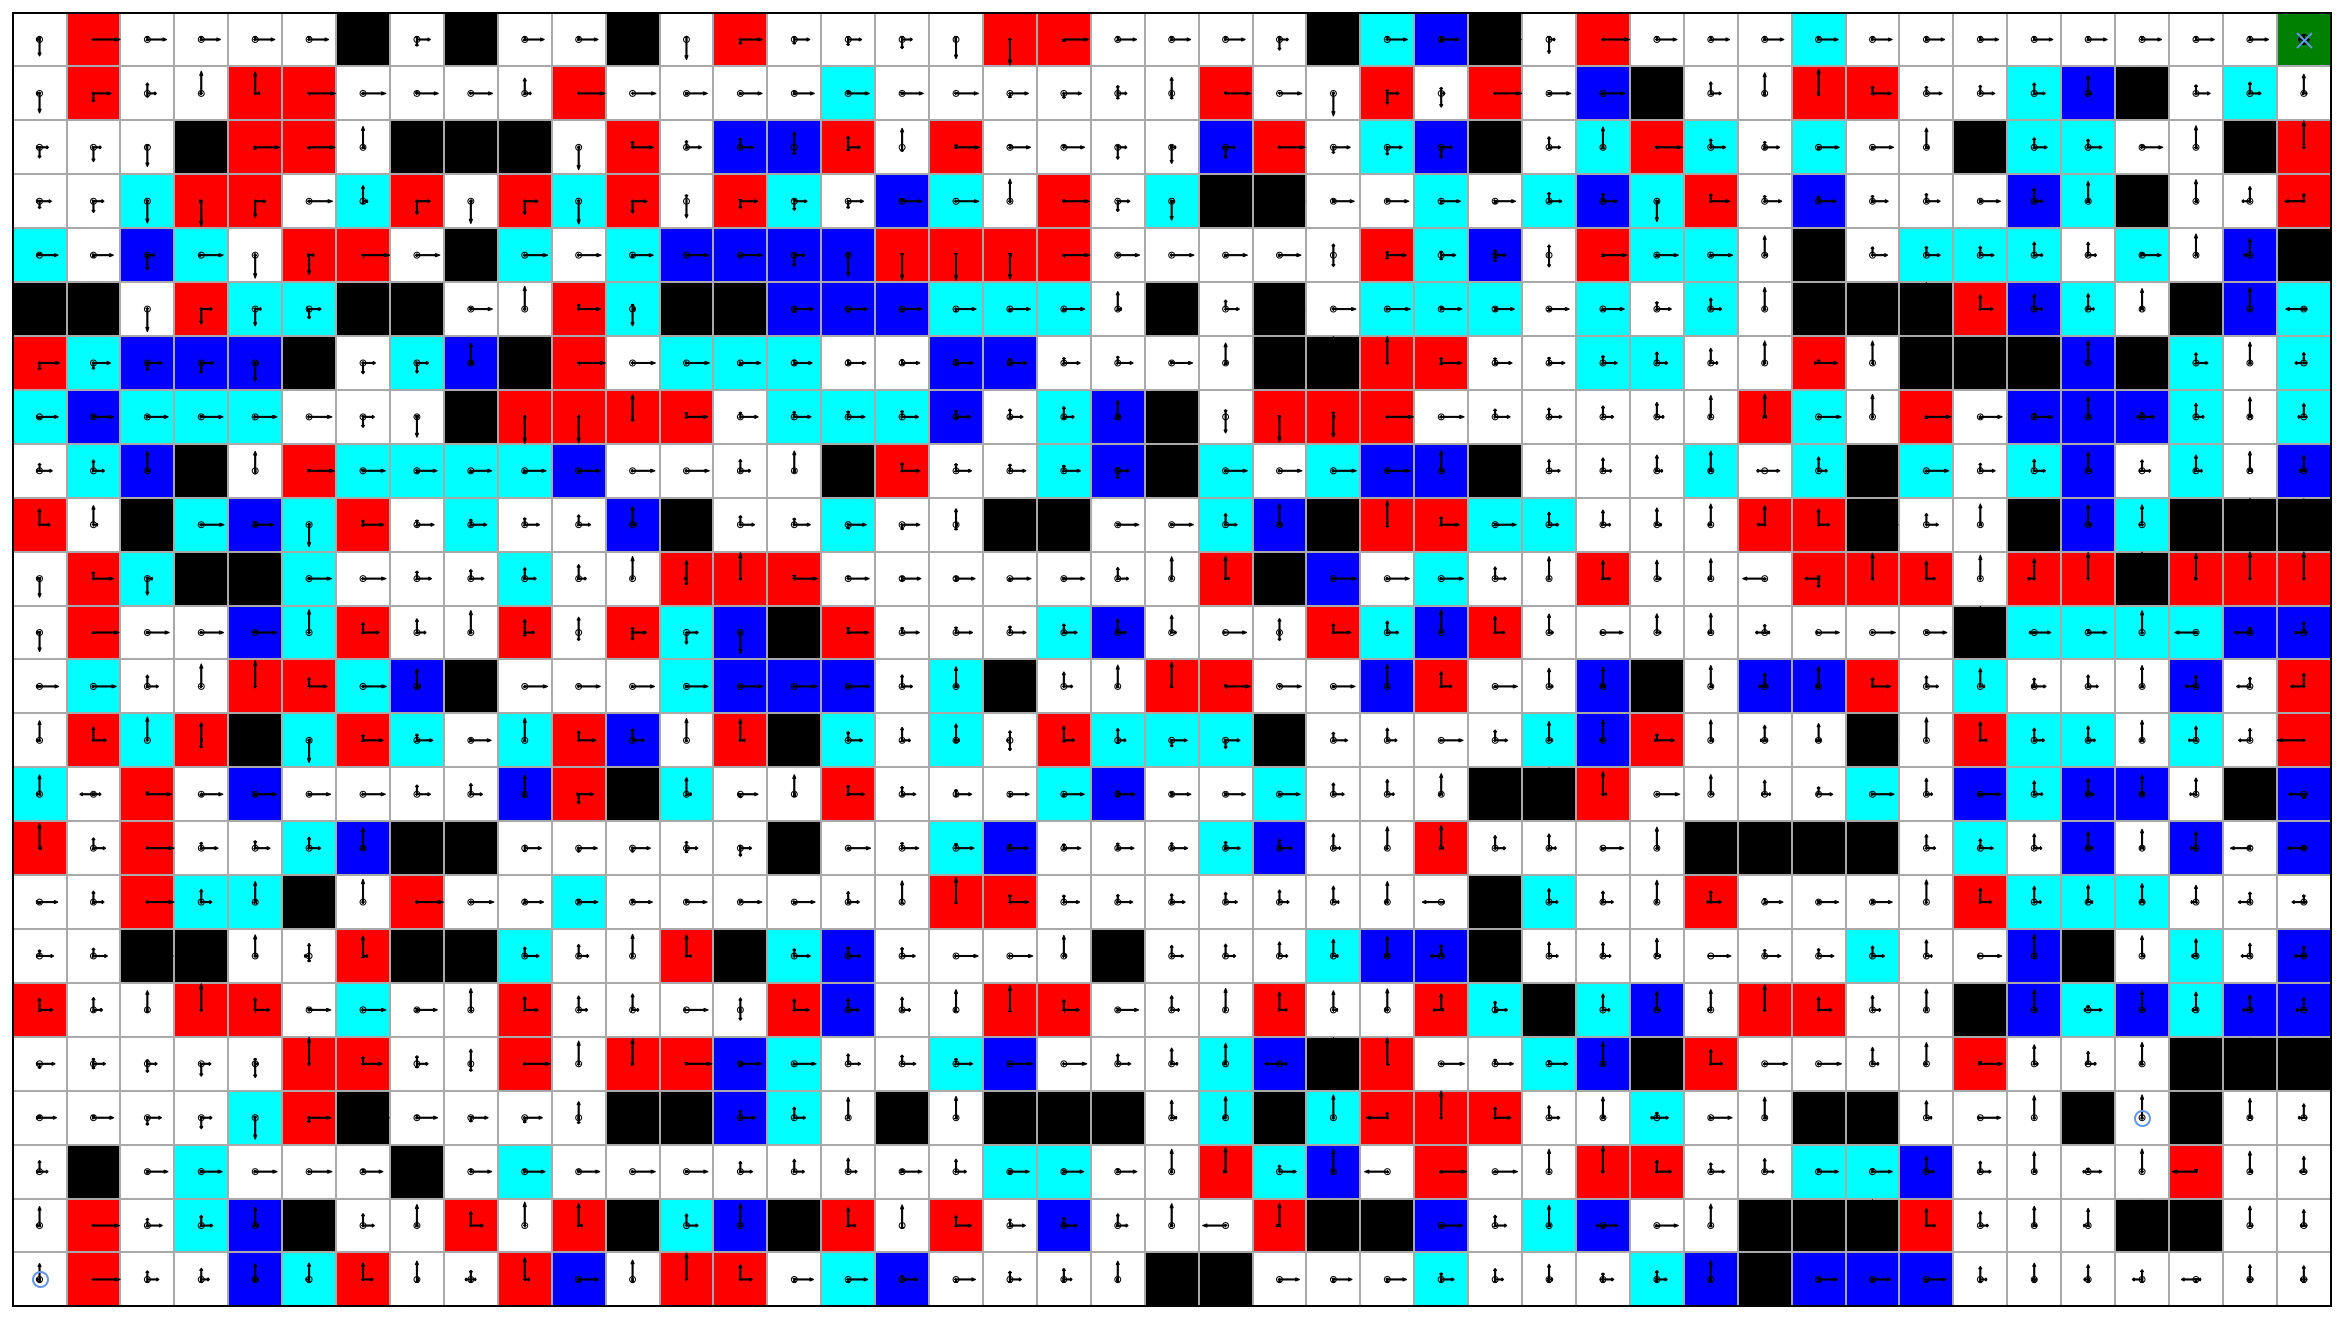

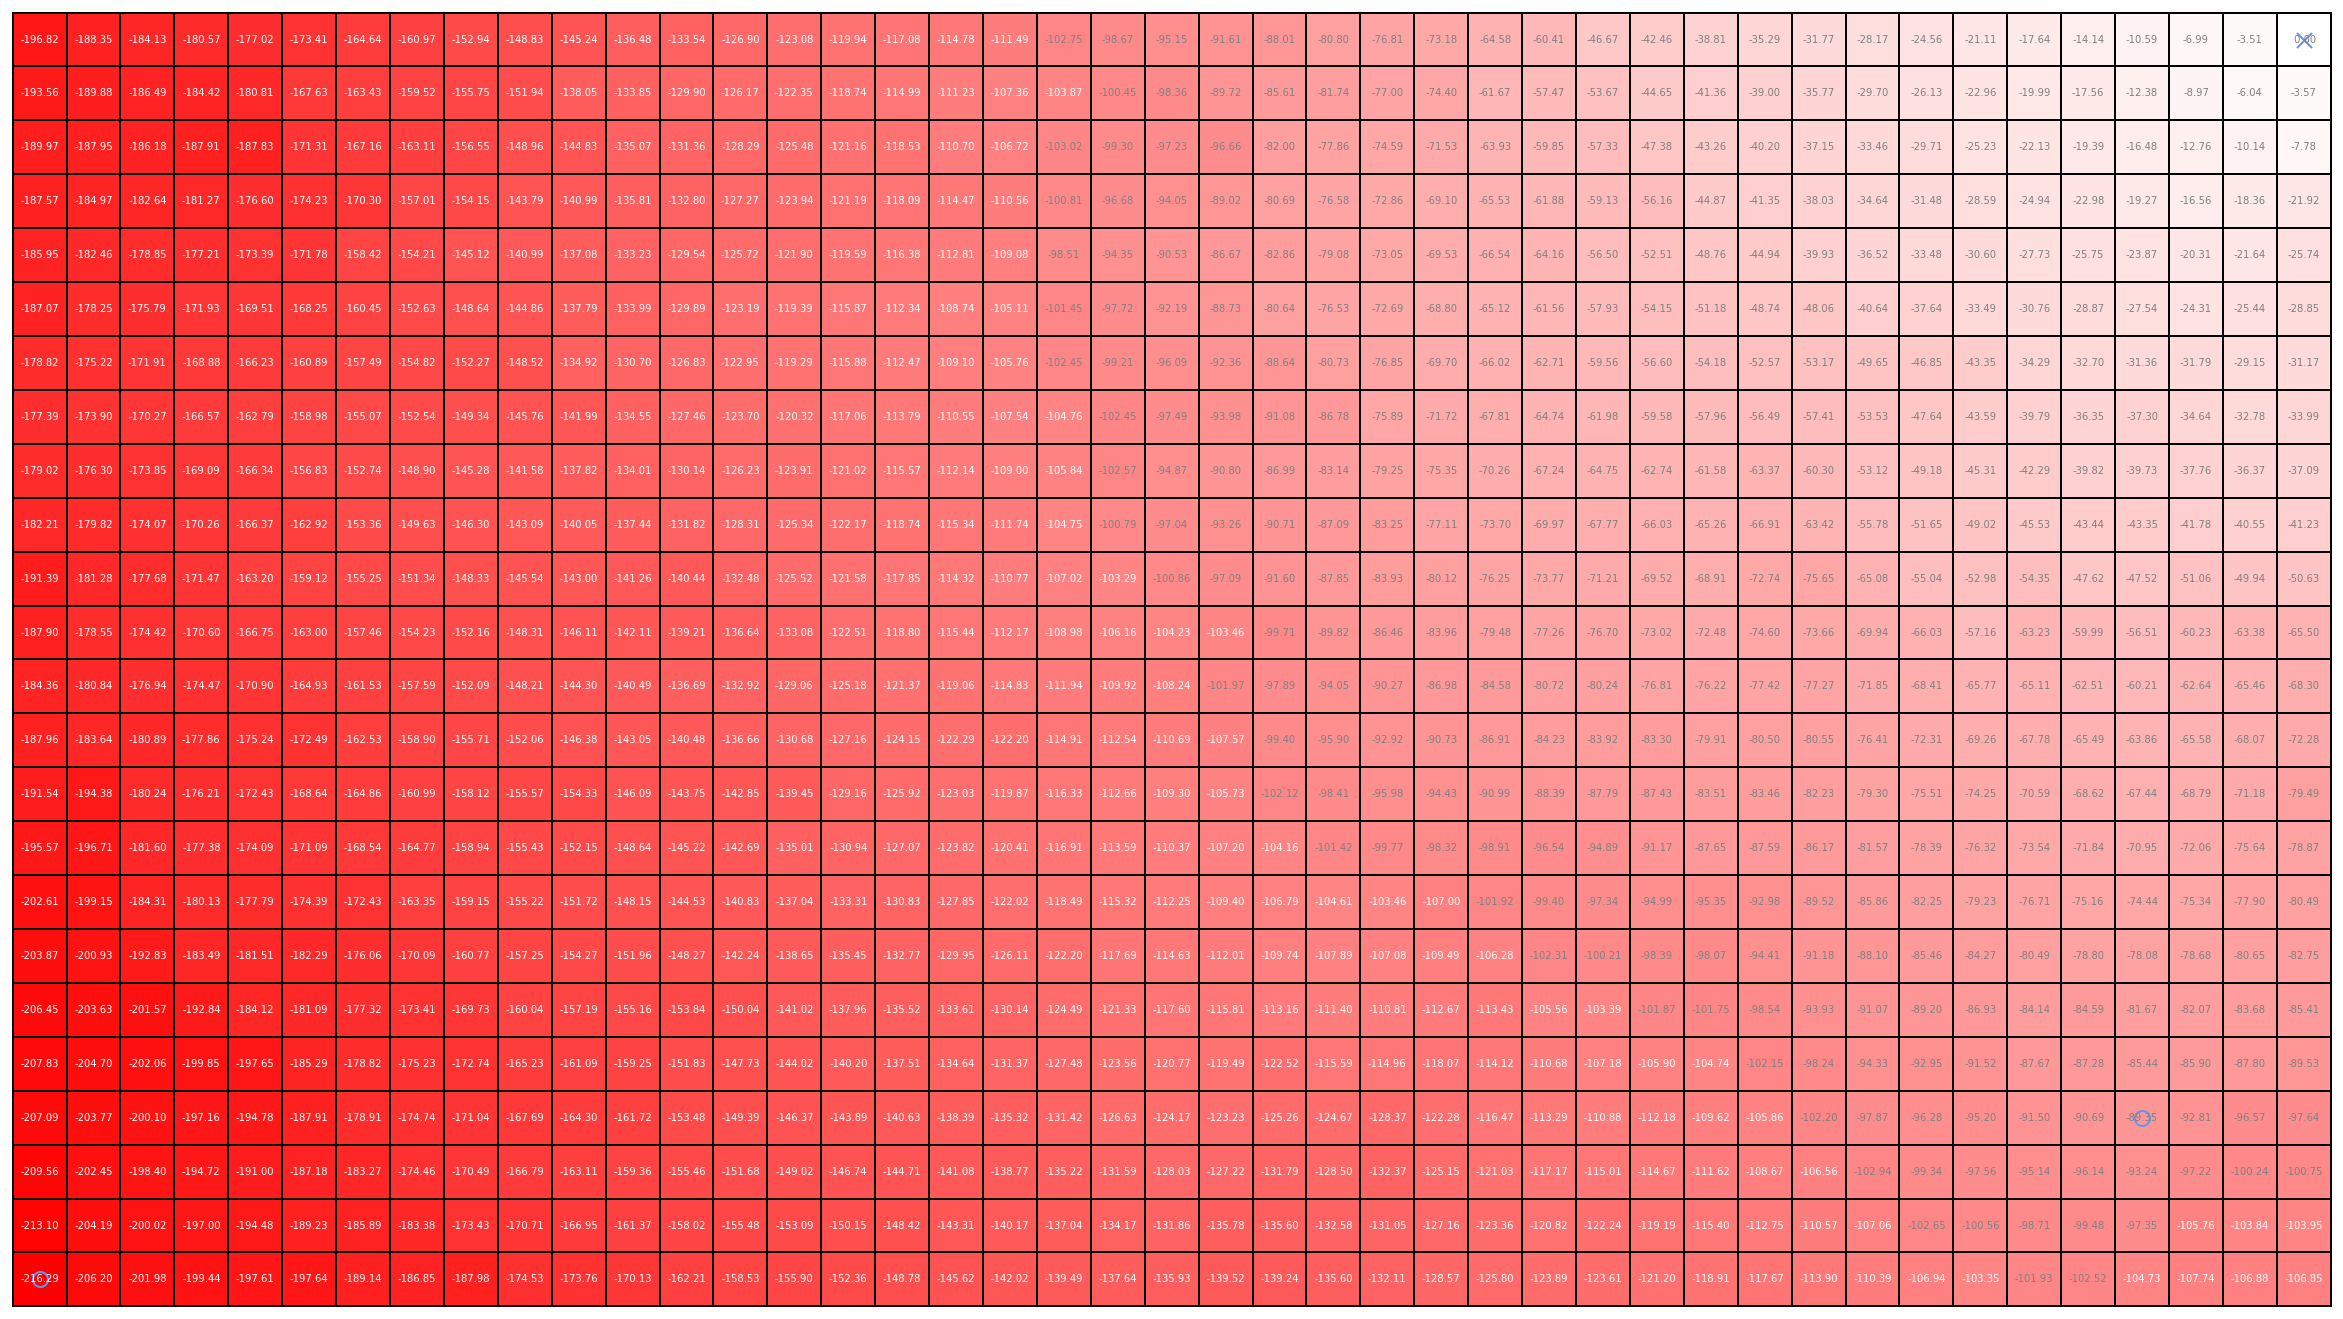

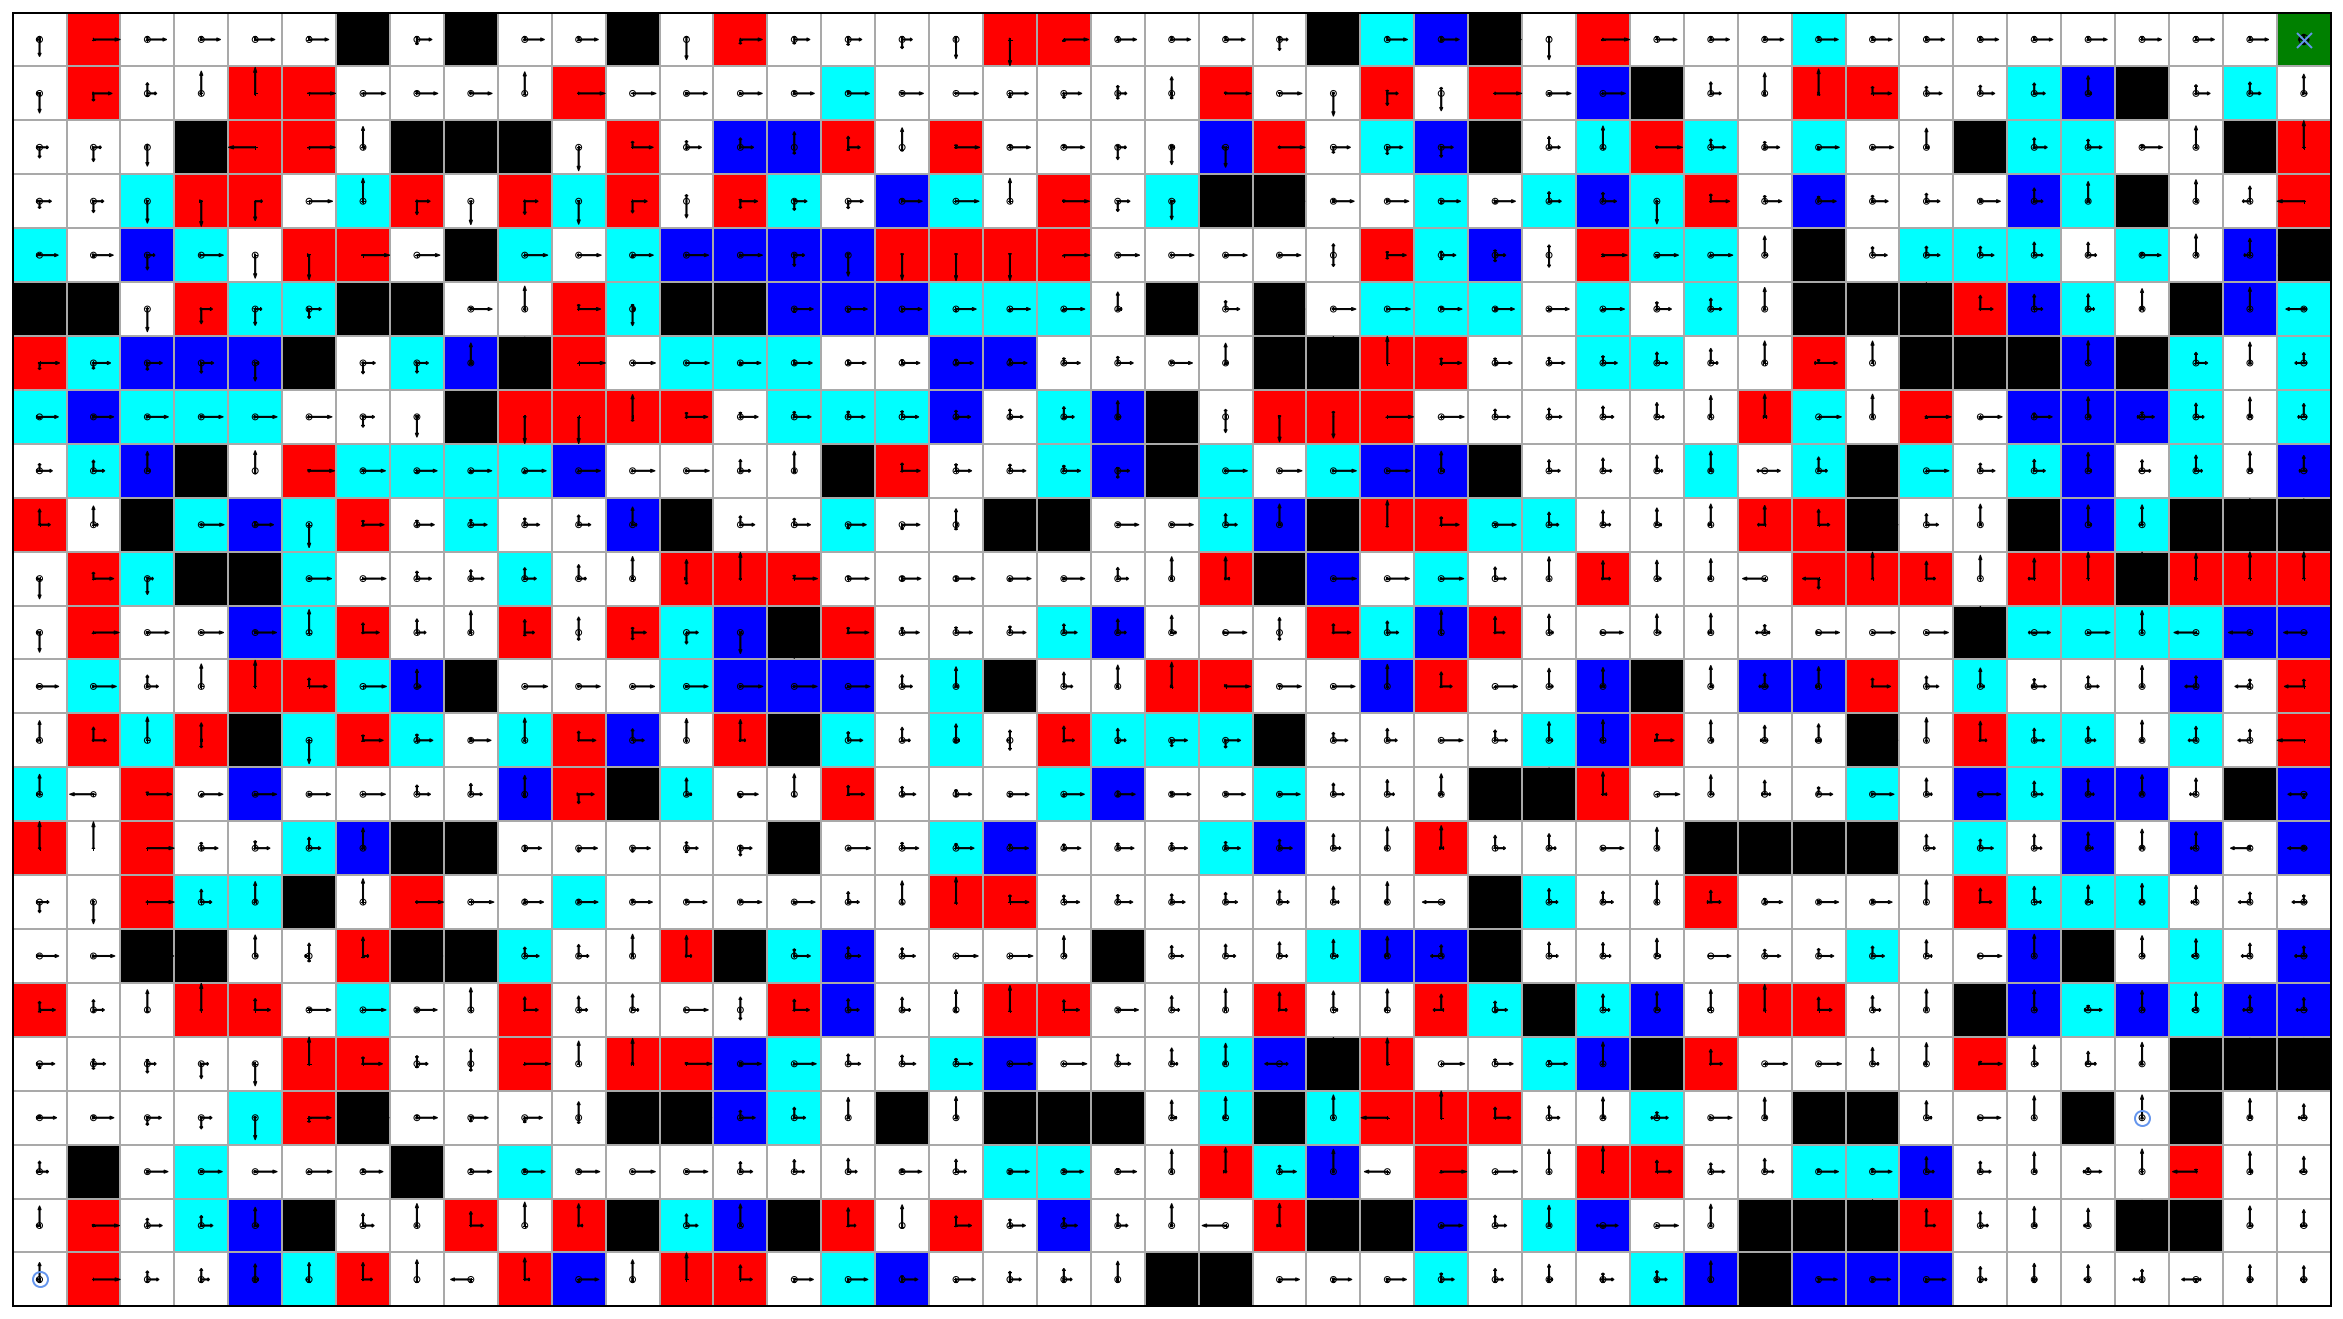

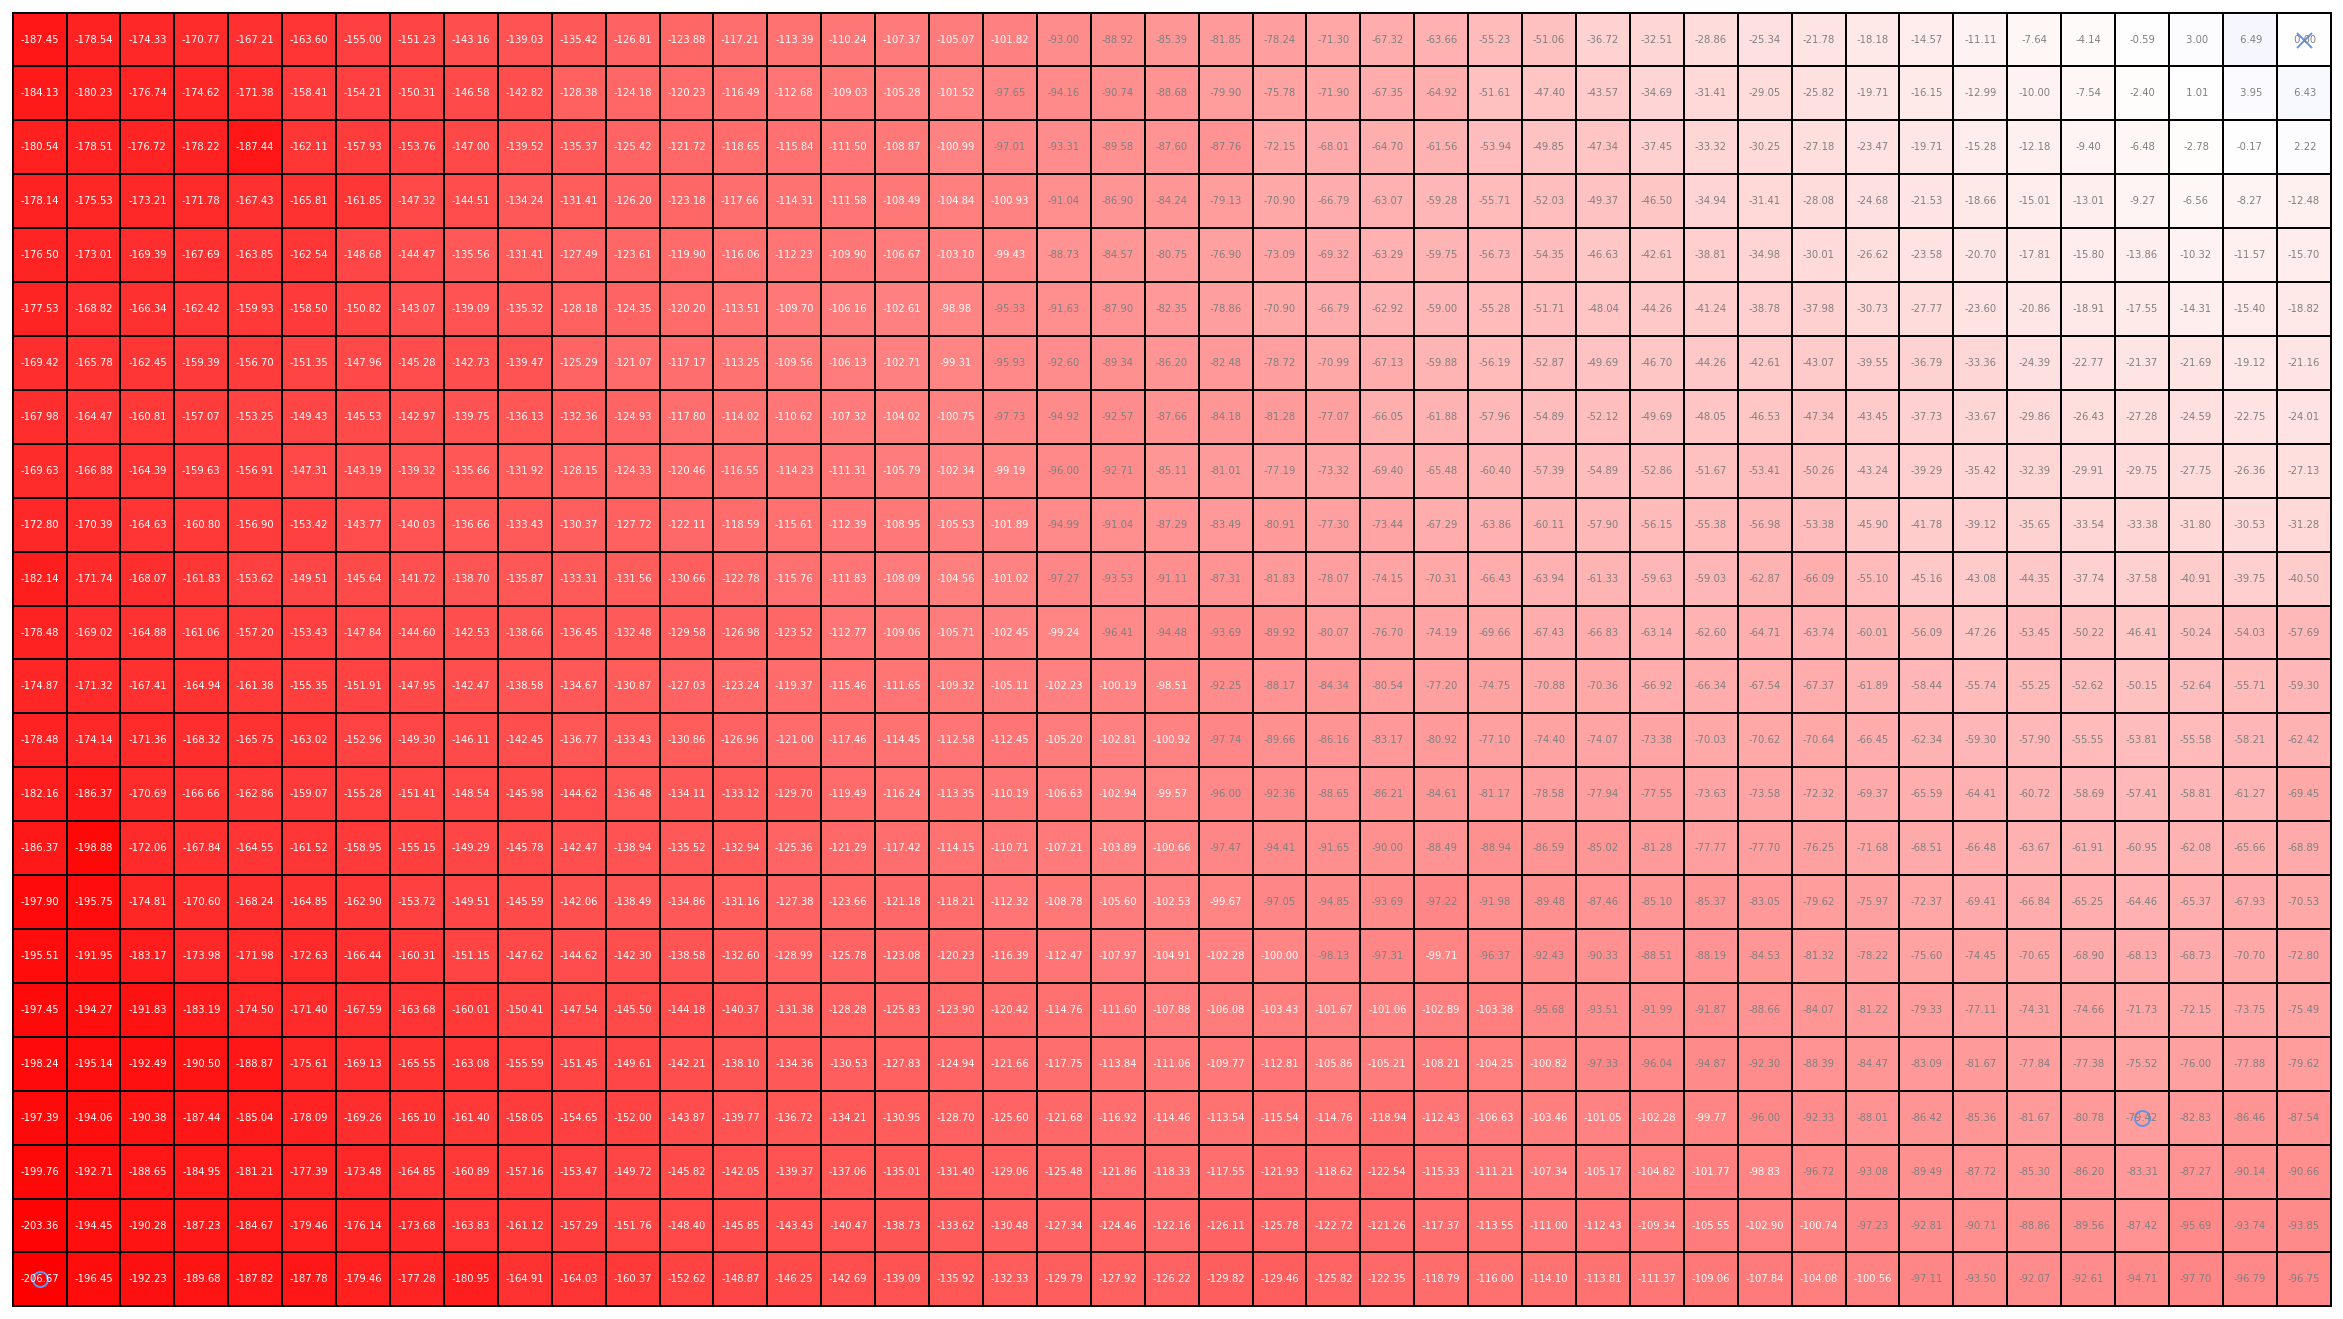

In [30]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)

my_state_values = dict(zip(mdp2.state_list, my_erpi.state_values.detach()))
mdp2.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp2.plot().plot_state_map(my_state_values)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [31]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp2).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp2).initial_value}")


Learned policy's initial value: -95.93288395047159
Expert's policy initial value: -59.7314469030557
